In [1]:
import pyedflib
import numpy as np
import scipy
from scipy import signal, misc
from matplotlib import pyplot as plt 
from glob import glob
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.metrics import confusion_matrix
from scipy.stats import sem
from scipy import mean
import seaborn as sns
from scipy import stats

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.metrics import classification_report, f1_score

import tensorflow.keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

from __future__ import print_function
from scipy.stats import norm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.constraints import max_norm
from sklearn.manifold import TSNE
from tensorflow.keras import models
from tensorflow.keras.layers import Concatenate, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Flatten

In [2]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# or 
GPU = 0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[GPU], True)

2022-01-25 14:27:57.667834: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-25 14:27:57.690522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 14:27:57.690745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:26:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-25 14:27:57.690942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-25 14:27:57.692384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-25 14:27:57.693912: I tensorflow/stream_executor/plat

In [3]:
T = 800 # Time point in each segment (freq. rate x 4s ec [4 sec/window])
C = 3
D = 6 # Dim (fs bands)
FS = 200 # Hz

In [4]:
def segment_data(Folder_name, label=0.):
    all_data_segment = glob('../LFP_Bank/'+Folder_name+'/*_200Hz.npy')

    data_all = []
    for indivi_file_segment in all_data_segment:
        print (indivi_file_segment)
        load_data = np.load(indivi_file_segment, allow_pickle=True)
        X, Y = load_data.shape
        N = int(Y/T) # Number of segment(s)
        data_new = []
        for i in range (N):
            data = load_data[:, i*T:((i+1)*T)]
            data_new.append(data)
        data_output = np.array(data_new)
        data_all.append(data_output)
        #print('=================================================================')
        #print(data_output)
        #print('=================================================================')
        #print('=============')
        #print(data_output.shape)
        #print('=============')
        #print('==============================================================================================================')
    X = np.array(data_all)
    y = np.full((X.shape[0], X.shape[1]), label)
    return X, y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [5]:
def triplet_loss(margin = 1.0):
    def inner_triplet_loss_objective(y_true, y_pred):
        labels = y_true
        embeddings = y_pred
        return tfa.losses.triplet_semihard_loss(y_true = labels, y_pred = embeddings, margin = margin)
    return inner_triplet_loss_objective

def dummy_loss(margin = 1.0):
    def inner(y_true, y_pred):
        return 0
    return inner

In [6]:
def build(num_class, F1=16, F2=8, P=(1, 10)):
    'encoder'
    encoder_input = Input(shape=(D, T, C))
    x = layers.Conv2D(F1, P, activation='elu', padding='same')(encoder_input)
    x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
    x = layers.AveragePooling2D(P, padding='same')(x)
    x = layers.Conv2D(F2, P, activation='elu', padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
    x = layers.AveragePooling2D(P, padding='same')(x)
#     x = layers.Conv2D(8, (1, 50), activation='elu', padding='same')(x)
#     x = layers.AveragePooling2D((1, 2), padding='same')(x)
    x = Flatten()(x)
    encoder_output = Dense(FS)(x)
    encoder        = models.Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
    encoder.summary()
    
    'decoder'
    decoder_input = Input(shape=(FS), name='decoder_input')
    x = Dense(D*(T//100)*F2, activation='elu')(decoder_input) 
    x = Reshape((D, T//100, F2))(x)
    x = layers.Conv2D(F2, P, activation='elu', padding='same')(x)
    x = layers.UpSampling2D(P)(x)
    x = layers.Conv2D(F1, P, activation='elu', padding='same')(x)
    x = layers.UpSampling2D(P)(x)
#     x = layers.Conv2D(16, (1, 10), activation='elu', padding='same')(x)
#     x = layers.UpSampling2D((1, 1))(x)
    decoder_output = layers.Conv2D(C, P, activation='elu', padding='same')(x)
    decoder        = models.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
    decoder.summary()
    
    'Build the computation graph for training'
    latent  = encoder(encoder_input)
    train_xr= decoder(latent)
    z       = Dense(units=num_class, activation='softmax', kernel_constraint=max_norm(0.5), name='classifier')(latent)

    return models.Model(inputs = [encoder_input], outputs = [train_xr, z],  name = 'AE')

In [7]:
# all_folders = ["00_Blank Syrup", '00_Control group',"00_PEG+Saline (control)", '01_PEG+1mg METH', '02_PEG+5mg METH',
#                '03_Morphine I (5 mg, ip)', '04_Morphine II (15 mg, ip)', '05_Cannabis project (THC 50 mg, ip)',
#                '06_MDMA project (10 mg, ip)', '07_L-DOPA project (25 mg in dw, po)', '08_Ephedrine group (10 mg, ip)',
#                '09_Pseudoephedrine group (50 mg, po)', '010_Pseudoephedrine group (100 mg, po)',
#                '011_Ketamine project (50 mg, ip)', '012_Lorazepam (1 mg, po)', '013_Lorazepam (5 mg, po)',
#                '014_Fluoxetine project (20 mg, po)', '015_KT alkaloid (60 mg, po)', '016_KT alkaloid (80 mg, po)',
#                '017_KT alkaloid (212 mg, cont equal to 10 mg per kg mitragynine, po)',
#                '018_Kratom (water extract) (cont equal to 10 mg per kg mitragynine, po)',
#                '019_Kratom Syrup (contained 10 mg mitragynine, po)', '020_Haloperidol (0_5 mg, po)',
#                '021_Haloperidol (1 mg, po)', '022_Haloperidol+Saline', '023_Haloperidol+5mg METH',
#                '024_Morphine II (15 mg, ip)+Naloxone (20 mg, ip)', '025_Jasmine project']

In [8]:
# X, y = final_output, np.hstack(([0]*10, [1]*10, [2]*10, [3]*8, [4]*9, [5]*8, [6]*7, [7]*12, [8]*7, [9]*12, [10]*12, [11]*7,
#                                 [12]*10, [13]*7, [14]*9, [15]*7, [16]*8, [17]*10, [18]*9, [19]*8, [20]*9, [21]*7, [22]*7,
#                                 [23]*10, [24]*10, [25]*9))

In [9]:
all_folders = ['00_PEG+Saline (control)', 
               '02_PEG+5mg METH',
               '04_Morphine II (15 mg, ip)',
               '05_Cannabis project (THC 50 mg, ip)',
               '06_MDMA project (10 mg, ip)',
               '07_L-DOPA project (25 mg in dw, po)', 
               '011_Ketamine project (50 mg, ip)', 
               '013_Lorazepam (5 mg, po)',
               '014_Fluoxetine project (20 mg, po)',
               '015_KT alkaloid (60 mg, po)']
#                '019_Kratom Syrup (contained 10 mg mitragynine, po)',
#                '025_Jasmine project']

In [10]:
# all_folders = ['00_Control group',
#                '02_PEG+5mg METH']

In [11]:
all_segmented_data = []
all_label = []
for i, fname in enumerate(all_folders):
    print (i)
    X_, y_ = segment_data(Folder_name=fname, label=i)
    all_segmented_data.append(X_)
    all_label.append(y_)
final_output = np.concatenate(np.array(all_segmented_data), axis = 0) # concatenate only axis 0
final_label = np.concatenate(np.array(all_label), axis = 0) # concatenate only axis 0
final_output.shape
final_label.shape

0
../LFP_Bank/00_PEG+Saline (control)/KT25-20191017-Naive Day 1_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A6-20190821-Vehicle_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A6-20191119-PEG+Saline_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/KT21-20190927-Naive Day 1_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A12-20191119-PEG+Saline_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A12-20190809-Vehicle_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A13-20191001-Naive Day1_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A8-20191125-PEG+Saline_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/KT21-20191013-Naive Day 2_200Hz.npy
../LFP_Bank/00_PEG+Saline (control)/A7-20190820-Vehicle_200Hz.npy
1
../LFP_Bank/02_PEG+5mg METH/KT29-20191014-METH+METH Day 1_200Hz.npy
../LFP_Bank/02_PEG+5mg METH/A7-20191019-METH+Vehicle Day 1_200Hz.npy
../LFP_Bank/02_PEG+5mg METH/A9-20191125-PEG+5mg METH_200Hz.npy
../LFP_Bank/02_PEG+5mg METH/A15-20191126-PEG+5mg METH_200Hz.npy
../LFP_Bank/02_PEG+5mg METH/A17-2019112

/tmp/ipykernel_2412/2047183342.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_output = np.concatenate(np.array(all_segmented_data), axis = 0) # concatenate only axis 0
/tmp/ipykernel_2412/2047183342.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_label = np.concatenate(np.array(all_label), axis = 0) # concatenate only axis 0


(86, 450)

In [12]:
X, y = final_output, final_label

In [13]:
X_new = np.zeros((X.shape[0], X.shape[1], D, X.shape[2], X.shape[3]))
for i in range (X.shape[0]):
#     print(i)
    for j in range (X.shape[1]):
#         print(j)
        delta = butter_bandpass_filter(data=X[i, j], lowcut=1, highcut=4, fs=FS, order=5)
        theta = butter_bandpass_filter(data=X[i, j], lowcut=4, highcut=9, fs=FS, order=5)
        alpha = butter_bandpass_filter(data=X[i, j], lowcut=9, highcut=13, fs=FS, order=5)
        beta = butter_bandpass_filter(data=X[i, j], lowcut=13, highcut=30, fs=FS, order=5)
        gamma_I = butter_bandpass_filter(data=X[i, j], lowcut=30, highcut=45, fs=FS, order=5)
        gamma_II = butter_bandpass_filter(data=X[i, j], lowcut=60, highcut=95, fs=FS, order=5)
        X_new[i, j] = np.array([delta, theta, alpha, beta, gamma_I, gamma_II])

In [14]:
def history_values(history):
    print(history.history.keys())
    val_classifier_accuracy = history.history['val_classifier_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    decoder_loss = history.history['decoder_loss']
    val_decoder_loss = history.history['val_decoder_loss']
    
    classifier_loss = history.history['classifier_loss']
    val_classifier_loss = history.history['val_classifier_loss']
    return val_classifier_accuracy, loss, val_loss, decoder_loss, val_decoder_loss, classifier_loss, val_classifier_loss

def plot_loss(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['val_classifier_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of traning iteration')
    plt.legend(['Classifier accuracy'], loc = 'lower right')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Total loss')
    plt.ylabel('Loss')
    plt.xlabel('Number of traning iteration')
    plt.legend(['Train', 'Validation'], loc = 'upper right')
    plt.show()
    
    plt.plot(history.history['decoder_loss'])
    plt.plot(history.history['val_decoder_loss'])
    plt.title('Mean squared error loss')
    plt.ylabel('Loss')
    plt.xlabel('Number of traning iteration')
    plt.legend(['Decoder_loss', 'Val_decoder_loss'], loc = 'upper right')
    plt.show() 
    
    plt.plot(history.history['classifier_loss'])
    plt.plot(history.history['val_classifier_loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('Loss')
    plt.xlabel('Number of traning iteration')
    plt.legend(['Classifier_loss', 'Val_classifier_loss'], loc = 'upper right')
    plt.show() 
    
def plot_tsne(decomposed_data, y_test):
    f, ax = plt.subplots(figsize = (10,8))
    steps=1
    for label in np.unique(y_test):
        if label == 0:
            text_label = "Con"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='black', 
                       linewidths=0.4, color='gray', marker='o', label = str(text_label))
        if label == 1:
            text_label = "Meth"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='firebrick',
                       linewidths=0.4, color='red', marker='o', label = str(text_label))
        if label == 2:
            text_label = "Mor"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='sienna',
                       linewidths=0.4, color='sandybrown', marker='o', label = str(text_label))
        if label == 3:
            text_label = "THC"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='tan',
                       linewidths=0.4, color='moccasin', marker='o', label = str(text_label))
        if label == 4:
            text_label = "MDMA"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='olivedrab',
                       linewidths=0.4, color='chartreuse', marker='o', label = str(text_label))
        if label == 5:
            text_label = "L-DOPA"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='seagreen',
                       linewidths=0.4, color='mediumspringgreen', marker='o', label = str(text_label))
        if label == 6:
            text_label = "Keta"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='darkcyan',
                       linewidths=0.4, color='darkturquoise', marker='o', label = str(text_label))
        if label == 7:
            text_label = "Lora"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='navy', 
                       linewidths=0.4, color='blue', marker='o', label = str(text_label))
        if label == 8:
            text_label = "Fluox"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='darkorchid',
                       linewidths=0.4, color='plum', marker='o', label = str(text_label))
        if label == 9:
            text_label = "AlkaKT"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='mediumvioletred',
                       linewidths=0.4, color='palevioletred', marker='o', label = str(text_label))
        if label == 10:
            text_label = "SyraKT"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='teal',
                       linewidths=0.4, color='cyan', marker='o', label = str(text_label))
        if label == 11:
            text_label = "Jas"
            decomposed_class = decomposed_data[label == y_test]
            ax.scatter(decomposed_class[::steps, 1], decomposed_class[::steps,0], s = 200, edgecolors='indigo',
                       linewidths=0.4, color='lightpink', marker='o', label = str(text_label))
    ax.legend()
    plt.show()
    

In [15]:
# Set channels last system
K.set_image_data_format('channels_last')
log_path="logs_3"
model_name="AE"
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [22]:
! pip install ipynbname

import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


FileNotFoundError: Can't identify the notebook name.

In [20]:
import json
import os
import urllib3
import IPython
from IPython.lib import kernel
connection_file_path = kernel.get_connection_file()
connection_file = os.path.basename(connection_file_path)
kernel_id = connection_file.split('-', 1)[1].split('.')[0]
sessions = json.load(urllib3.urlopen('http://127.0.0.1:8888/api/sessions%27'))

for sess in sessions:
    if sess['kernel']['id'] == kernel_id:
        print(sess['notebook']['name'])
        break

AttributeError: module 'urllib3' has no attribute 'urlopen'

In [16]:
def fit_model(X, y, epochs, batch_size):
    
    X = X.reshape(-1,D,C,T)
    X = np.swapaxes(X, 2, 3)
    
    yl = y.reshape(-1)
    
    ys = np.arange(y.shape[0])
    ys = np.repeat([ys], y.shape[1], axis=0)
    ys = np.swapaxes(ys, 0, 1)
    ys = ys.reshape(-1)
            
    skf = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
    skf.get_n_splits(X, ys)
    print(skf)
    
    fold=0
    y_true_all, y_pred_all, scores_all, clas_report_all  = [], [], [], []
    val_clas_acc_all, loss_all, val_loss_all, dec_loss_all = [], [], [], []
    val_dec_loss_all, clas_loss_all, val_clas_loss_all = [], [], []
    
    for learn_index, test_index in skf.split(X, ys):
        print("LEARN:", learn_index, "TEST:", test_index)
        X_learn, X_test = X[learn_index], X[test_index]
#         print('X_learn:', X_learn)
        y_learn, y_test = yl[learn_index], yl[test_index]
#         print('y_learn:', y_learn)
        ys_learn, ys_test = ys[learn_index], ys[test_index]
#         print('ys_learn:', ys_learn)

        skf_train = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
        skf_train.get_n_splits(X_learn, ys_learn)
        print(skf_train)
        
        y_true_fold, y_pred_fold, scores_fold, clas_report_fold = [], [], [], []
        val_clas_acc_fold, loss_fold, val_loss_fold, dec_loss_fold = [], [], [], []
        val_dec_loss_fold, clas_loss_fold, val_clas_loss_fold = [], [], []
        
        for train_index, val_index in skf_train.split(X_learn, ys_learn):
            print("TRAIN:", train_index, "VAL:", val_index)
            X_train, X_val = X_learn[train_index], X_learn[val_index]
#             print('X_train:', X_train)
#             print('X_val:', X_val)
            y_train, y_val = y_learn[train_index], y_learn[val_index]
#             print('y_train:', y_train)
            ys_train, ys_val = ys_learn[train_index], ys_learn[val_index]
#             print('ys_train:', ys_train)
            
            y_train_dummy = np.zeros_like(y_train)
            y_val_dummy = np.zeros_like(y_val)
            y_test_dummy = np.zeros_like(y_test)
            
            fold += 1
            
            # reset model
            weights_dir = log_path+'/'+model_name+'_out_weights'+str(fold)+'.h5'
            num_class = len(np.unique(y))
            model = build(num_class = num_class)
            model.summary()
            optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
            model.compile(optimizer = optimizer, 
                          loss = ['mean_squared_error', 'sparse_categorical_crossentropy'],
                          metrics = ['accuracy'], loss_weights = [1., 1.])
              
            # set callbacks
            checkpointer  = ModelCheckpoint(monitor='val_loss',
                                            filepath=log_path+'/'+model_name+'_out_weights'+str(fold)+'.h5', 
                                            verbose=1, save_best_only=True, save_weight_only=True)
            csv_logger    = CSVLogger(log_path+'/'+model_name+'_out_log'+str(fold)+'.log')
            reduce_lr     = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, mode='min',
                                              verbose=1, min_lr=1e-5)
            es            = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) 
                            # patience = save data at n ecoch followed by 10 bad epoch and stop 
            
            # fit model
            history = model.fit(x = X_train, y = [X_train, y_train], 
                            epochs = epochs, # n of cycle for training 
                            shuffle = True, 
                            batch_size = batch_size, 
                            validation_data = (X_val, [X_val, y_val]),
                            callbacks=[checkpointer, csv_logger, reduce_lr, es])
            
            val_clas_acc, loss, val_loss, dec_loss, val_dec_loss, clas_loss, val_clas_loss = history_values(history)
            
            val_clas_acc_fold.append(val_clas_acc)
            loss_fold.append(loss)
            val_loss_fold.append(val_loss)
            dec_loss_fold.append(dec_loss)
            val_dec_loss_fold.append(val_dec_loss)
            clas_loss_fold.append(clas_loss)
            val_clas_loss_fold.append(val_clas_loss)
            
            def build_test():
                model = build(num_class = num_class)
                encoder_input = model.layers[0].output
                encoder = model.layers[1]
                decoder = model.layers[2]
                classifier = model.layers[3]
                latent = encoder(encoder_input)
                train_xr = decoder(latent)
                z = classifier(latent)
                model = models.Model(inputs = [encoder_input], outputs = [latent, train_xr, z],  name = 'AE')
                model.compile(optimizer = optimizer, 
                              loss = [triplet_loss(margin=1.), 'mean_squared_error', 'sparse_categorical_crossentropy'],
                              metrics = ['accuracy'], loss_weights = [0., 1., 1.])
                return model
            
            model = build_test()
            model.load_weights(weights_dir)
            model.save()
            latent, train_xr, z = model.predict(X_test, batch_size = batch_size)
            
            y_true_fold.append(y_test)
            y_pred = np.argmax(z, axis=1)
            y_pred_fold.append(y_pred)
            
            print(model.evaluate(x = X_test, y = [y_test_dummy, X_test, y_test]))
            print(classification_report(y_test, y_pred, output_dict=True))
            
            scores = model.evaluate(x = X_test, y = [y_test_dummy, X_test, y_test])
            clas_report = classification_report(y_test, y_pred, output_dict=True)
        
            scores_fold.append(scores)
            clas_report_fold.append(clas_report)
                           
            tsne = TSNE(n_components = 2, random_state = 42)
            decomposed_data = tsne.fit_transform(latent)
            
            # plot loss
            plot_loss(history)
            plot_tsne(decomposed_data, y_test)
            
            K.clear_session()
            
        val_clas_acc_all.append(val_clas_acc_fold)
        val_clas_acc_all_data = np.array(val_clas_acc_all)
        loss_all.append(loss_fold)
        loss_all_data = np.array(loss_all)
        val_loss_all.append(val_loss_fold)
        val_loss_all_data = np.array(val_loss_all)
        dec_loss_all.append(dec_loss_fold)
        dec_loss_all_data = np.array(dec_loss_all)
        val_dec_loss_all.append(val_dec_loss_fold)
        val_dec_loss_all_data = np.array(val_dec_loss_all)
        clas_loss_all.append(clas_loss_fold)
        clas_loss_all_data = np.array(clas_loss_all)
        val_clas_loss_all.append(val_clas_loss_fold)
        val_clas_loss_all_data = np.array(val_clas_loss_all)
        
        y_true_all.append(y_true_fold)
        y_true_all_data = np.array(y_true_all)
        
        y_pred_all.append(y_pred_fold)
        y_pred_all_data = np.array(y_pred_all)
        
        scores_all.append(scores_fold)
        scores_all_data = np.array(scores_all)
        
        clas_report_all.append(clas_report_fold)
        clas_report_all_data = np.array(clas_report_all)
    
    return (val_clas_acc_all_data, loss_all_data, val_loss_all_data, dec_loss_all_data, val_dec_loss_all_data,
            clas_loss_all_data, val_clas_loss_all_data, y_true_all_data, y_pred_all_data, scores_all_data,
            clas_report_all_data, train_xr, z, fold)

StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
LEARN: [    0     1     4 ... 38690 38694 38697] TEST: [    2     3     5 ... 38696 38698 38699]
StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     3 ... 19347 19348 19349] VAL: [    0    11    13 ... 19332 19335 19343]


2022-01-25 14:29:50.465663: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-25 14:29:50.492244: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3692650000 Hz
2022-01-25 14:29:50.492833: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2378000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-25 14:29:50.492854: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-25 14:29:50.705012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 14:29:50.705293: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55979371a140 initialized for platform CUDA (this does not guarantee that XLA

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 8, 8)           0   

2022-01-25 14:29:53.166779: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-25 14:29:53.323559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


121/121 [==============================] - ETA: 0s - loss: 2.2037 - decoder_loss: 0.0075 - classifier_loss: 2.1961 - decoder_accuracy: 0.3330 - classifier_accuracy: 0.2118
Epoch 00001: val_loss improved from inf to 2.06845, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 29ms/step - loss: 2.2037 - decoder_loss: 0.0075 - classifier_loss: 2.1961 - decoder_accuracy: 0.3330 - classifier_accuracy: 0.2118 - val_loss: 2.0685 - val_decoder_loss: 0.0035 - val_classifier_loss: 2.0649 - val_decoder_accuracy: 0.3327 - val_classifier_accuracy: 0.3227 - lr: 1.0000e-04
Epoch 2/71
121/121 [==============================] - ETA: 0s - loss: 1.9381 - decoder_loss: 0.0028 - classifier_loss: 1.9353 - decoder_accuracy: 0.3333 - classifier_accuracy: 0.3868
Epoch 00002: val_loss improved from 2.06845 to 1.81035, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.9381 - decoder_loss: 0.0028 - classifier_loss: 1.935

Epoch 15/71
121/121 [==============================] - ETA: 0s - loss: 0.9476 - decoder_loss: 0.0014 - classifier_loss: 0.9462 - decoder_accuracy: 0.3347 - classifier_accuracy: 0.6780
Epoch 00015: val_loss improved from 0.98884 to 0.95446, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.9476 - decoder_loss: 0.0014 - classifier_loss: 0.9462 - decoder_accuracy: 0.3347 - classifier_accuracy: 0.6780 - val_loss: 0.9545 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.9531 - val_decoder_accuracy: 0.3342 - val_classifier_accuracy: 0.6716 - lr: 1.0000e-04
Epoch 16/71
121/121 [==============================] - ETA: 0s - loss: 0.9281 - decoder_loss: 0.0014 - classifier_loss: 0.9267 - decoder_accuracy: 0.3347 - classifier_accuracy: 0.6848
Epoch 00016: val_loss improved from 0.95446 to 0.94144, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.9281 - decoder_loss: 0.0014 - class

Epoch 29/71
121/121 [==============================] - ETA: 0s - loss: 0.7778 - decoder_loss: 0.0013 - classifier_loss: 0.7765 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.7395
Epoch 00029: val_loss improved from 0.81460 to 0.81265, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7778 - decoder_loss: 0.0013 - classifier_loss: 0.7765 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.7395 - val_loss: 0.8127 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.8113 - val_decoder_accuracy: 0.3343 - val_classifier_accuracy: 0.7233 - lr: 1.0000e-04
Epoch 30/71
121/121 [==============================] - ETA: 0s - loss: 0.7678 - decoder_loss: 0.0013 - classifier_loss: 0.7665 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.7453
Epoch 00030: val_loss improved from 0.81265 to 0.80198, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.7678 - decoder_loss: 0.0013 - class

Epoch 43/71
121/121 [==============================] - ETA: 0s - loss: 0.6417 - decoder_loss: 0.0013 - classifier_loss: 0.6404 - decoder_accuracy: 0.3375 - classifier_accuracy: 0.7927
Epoch 00043: val_loss did not improve from 0.67171
121/121 [==============================] - 3s 23ms/step - loss: 0.6417 - decoder_loss: 0.0013 - classifier_loss: 0.6404 - decoder_accuracy: 0.3375 - classifier_accuracy: 0.7927 - val_loss: 0.6839 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.6827 - val_decoder_accuracy: 0.3392 - val_classifier_accuracy: 0.7682 - lr: 1.0000e-04
Epoch 44/71
121/121 [==============================] - ETA: 0s - loss: 0.6288 - decoder_loss: 0.0013 - classifier_loss: 0.6275 - decoder_accuracy: 0.3378 - classifier_accuracy: 0.7975
Epoch 00044: val_loss did not improve from 0.67171
121/121 [==============================] - 3s 23ms/step - loss: 0.6288 - decoder_loss: 0.0013 - classifier_loss: 0.6275 - decoder_accuracy: 0.3378 - classifier_accuracy: 0.7975 - val_loss: 0.6774

Epoch 57/71
121/121 [==============================] - ETA: 0s - loss: 0.5081 - decoder_loss: 0.0013 - classifier_loss: 0.5068 - decoder_accuracy: 0.3422 - classifier_accuracy: 0.8386
Epoch 00057: val_loss did not improve from 0.55512
121/121 [==============================] - 3s 23ms/step - loss: 0.5081 - decoder_loss: 0.0013 - classifier_loss: 0.5068 - decoder_accuracy: 0.3422 - classifier_accuracy: 0.8386 - val_loss: 0.5565 - val_decoder_loss: 0.0012 - val_classifier_loss: 0.5553 - val_decoder_accuracy: 0.3448 - val_classifier_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 58/71
121/121 [==============================] - ETA: 0s - loss: 0.5020 - decoder_loss: 0.0013 - classifier_loss: 0.5008 - decoder_accuracy: 0.3425 - classifier_accuracy: 0.8428
Epoch 00058: val_loss improved from 0.55512 to 0.54508, saving model to logs_3/AE_out_weights1.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.5020 - decoder_loss: 0.0013 - classifier_loss: 0.5008 - decoder_accuracy: 0.3425 -

Epoch 71/71
118/121 [============================>.] - ETA: 0s - loss: 0.4415 - decoder_loss: 0.0012 - classifier_loss: 0.4403 - decoder_accuracy: 0.3454 - classifier_accuracy: 0.8592
Epoch 00071: val_loss did not improve from 0.49828

Epoch 00071: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
121/121 [==============================] - 3s 23ms/step - loss: 0.4416 - decoder_loss: 0.0012 - classifier_loss: 0.4403 - decoder_accuracy: 0.3454 - classifier_accuracy: 0.8589 - val_loss: 0.5099 - val_decoder_loss: 0.0012 - val_classifier_loss: 0.5087 - val_decoder_accuracy: 0.3454 - val_classifier_accuracy: 0.8398 - lr: 1.0000e-04
dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              P

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


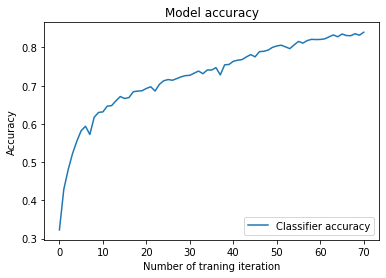

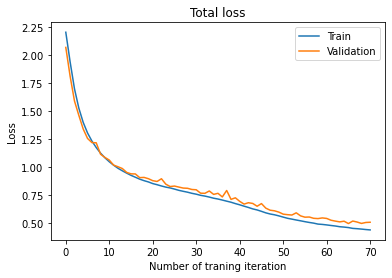

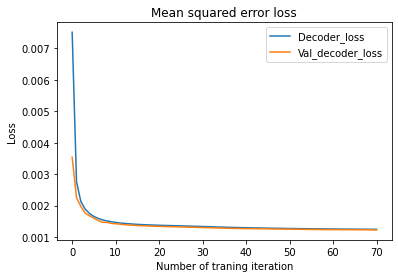

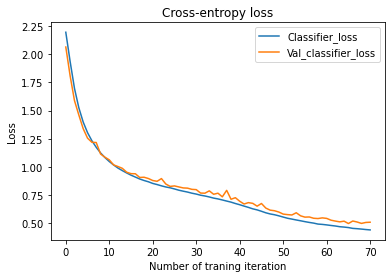

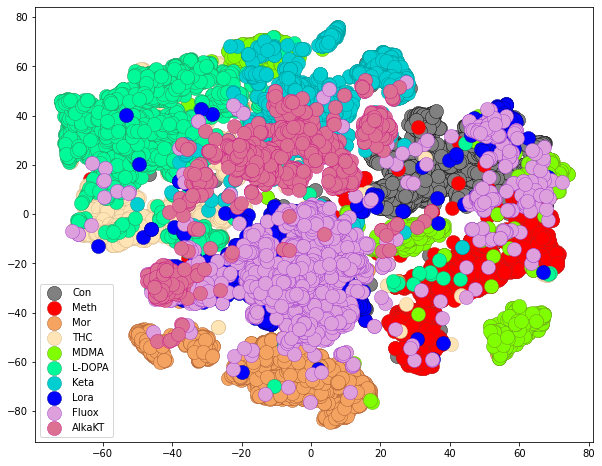

TRAIN: [    0     1     2 ... 19346 19347 19349] VAL: [    7    10    15 ... 19339 19340 19348]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.1841 - decoder_loss: 0.0015 - classifier_loss: 1.1825 - decoder_accuracy: 0.3324 - classifier_accuracy: 0.6154
Epoch 00008: val_loss improved from 1.21912 to 1.19871, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1841 - decoder_loss: 0.0015 - classifier_loss: 1.1825 - decoder_accuracy: 0.3324 - classifier_accuracy: 0.6154 - val_loss: 1.1987 - val_decoder_loss: 0.0015 - val_classifier_loss: 1.1972 - val_decoder_accuracy: 0.3321 - val_classifier_accuracy: 0.5997 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1374 - decoder_loss: 0.0015 - classifier_loss: 1.1359 - decoder_accuracy: 0.3324 - classifier_accuracy: 0.6285
Epoch 00009: val_loss improved from 1.19871 to 1.13462, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1374 - decoder_loss: 0.0015 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8676 - decoder_loss: 0.0014 - classifier_loss: 0.8662 - decoder_accuracy: 0.3327 - classifier_accuracy: 0.7087
Epoch 00022: val_loss improved from 0.93323 to 0.92162, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8676 - decoder_loss: 0.0014 - classifier_loss: 0.8662 - decoder_accuracy: 0.3327 - classifier_accuracy: 0.7087 - val_loss: 0.9216 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.9203 - val_decoder_accuracy: 0.3327 - val_classifier_accuracy: 0.6804 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8589 - decoder_loss: 0.0014 - classifier_loss: 0.8575 - decoder_accuracy: 0.3328 - classifier_accuracy: 0.7079
Epoch 00023: val_loss improved from 0.92162 to 0.90893, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8589 - decoder_loss: 0.0014 - class

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7623 - decoder_loss: 0.0013 - classifier_loss: 0.7610 - decoder_accuracy: 0.3348 - classifier_accuracy: 0.7379
Epoch 00036: val_loss did not improve from 0.82776
121/121 [==============================] - 3s 24ms/step - loss: 0.7623 - decoder_loss: 0.0013 - classifier_loss: 0.7610 - decoder_accuracy: 0.3348 - classifier_accuracy: 0.7379 - val_loss: 0.8335 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.8322 - val_decoder_accuracy: 0.3351 - val_classifier_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.7586 - decoder_loss: 0.0013 - classifier_loss: 0.7573 - decoder_accuracy: 0.3349 - classifier_accuracy: 0.7415
Epoch 00037: val_loss improved from 0.82776 to 0.82714, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.7586 - decoder_loss: 0.0013 - classifier_loss: 0.7573 - decoder_accuracy: 0.3349 -

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.6957 - decoder_loss: 0.0013 - classifier_loss: 0.6945 - decoder_accuracy: 0.3388 - classifier_accuracy: 0.7706
Epoch 00050: val_loss improved from 0.78492 to 0.78132, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6957 - decoder_loss: 0.0013 - classifier_loss: 0.6945 - decoder_accuracy: 0.3388 - classifier_accuracy: 0.7706 - val_loss: 0.7813 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7801 - val_decoder_accuracy: 0.3414 - val_classifier_accuracy: 0.7302 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.6921 - decoder_loss: 0.0013 - classifier_loss: 0.6908 - decoder_accuracy: 0.3393 - classifier_accuracy: 0.7661
Epoch 00051: val_loss improved from 0.78132 to 0.77356, saving model to logs_3/AE_out_weights2.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.6921 - decoder_loss: 0.0013 - class

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.6459 - decoder_loss: 0.0012 - classifier_loss: 0.6447 - decoder_accuracy: 0.3452 - classifier_accuracy: 0.7870
Epoch 00064: val_loss did not improve from 0.73852
121/121 [==============================] - 3s 23ms/step - loss: 0.6459 - decoder_loss: 0.0012 - classifier_loss: 0.6447 - decoder_accuracy: 0.3452 - classifier_accuracy: 0.7870 - val_loss: 0.7404 - val_decoder_loss: 0.0012 - val_classifier_loss: 0.7392 - val_decoder_accuracy: 0.3460 - val_classifier_accuracy: 0.7483 - lr: 1.0000e-04
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.6432 - decoder_loss: 0.0012 - classifier_loss: 0.6419 - decoder_accuracy: 0.3455 - classifier_accuracy: 0.7874
Epoch 00065: val_loss did not improve from 0.73852
121/121 [==============================] - 3s 23ms/step - loss: 0.6432 - decoder_loss: 0.0012 - classifier_loss: 0.6419 - decoder_accuracy: 0.3455 - classifier_accuracy: 0.7874 - val_loss: 0.7640

605/605 [==============================] - 3s 5ms/step - loss: 0.6909 - encoder_loss: 19.5402 - decoder_loss: 0.0012 - classifier_loss: 0.6897 - encoder_accuracy: 1.0336e-04 - decoder_accuracy: 0.3483 - classifier_accuracy: 0.7705


/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


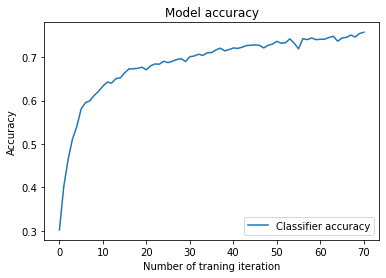

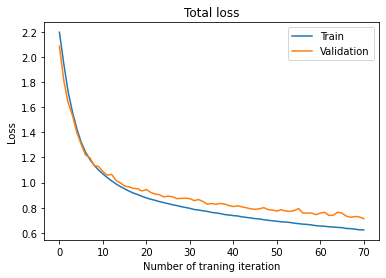

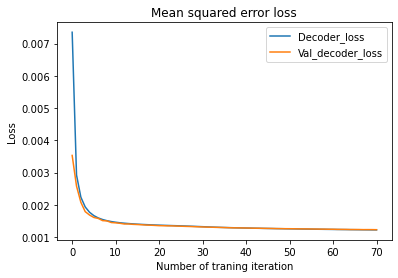

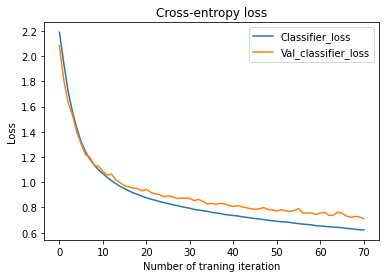

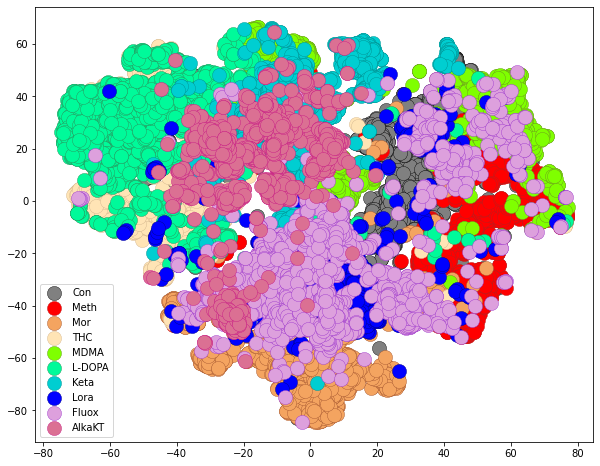

TRAIN: [    0     1     3 ... 19346 19347 19348] VAL: [    2    18    24 ... 19333 19336 19349]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.1810 - decoder_loss: 0.0016 - classifier_loss: 1.1795 - decoder_accuracy: 0.3363 - classifier_accuracy: 0.6114
Epoch 00008: val_loss improved from 1.22396 to 1.15439, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1810 - decoder_loss: 0.0016 - classifier_loss: 1.1795 - decoder_accuracy: 0.3363 - classifier_accuracy: 0.6114 - val_loss: 1.1544 - val_decoder_loss: 0.0016 - val_classifier_loss: 1.1528 - val_decoder_accuracy: 0.3360 - val_classifier_accuracy: 0.6194 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1346 - decoder_loss: 0.0015 - classifier_loss: 1.1331 - decoder_accuracy: 0.3363 - classifier_accuracy: 0.6249
Epoch 00009: val_loss improved from 1.15439 to 1.11184, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1346 - decoder_loss: 0.0015 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8534 - decoder_loss: 0.0014 - classifier_loss: 0.8521 - decoder_accuracy: 0.3356 - classifier_accuracy: 0.7089
Epoch 00022: val_loss improved from 0.87311 to 0.85362, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8534 - decoder_loss: 0.0014 - classifier_loss: 0.8521 - decoder_accuracy: 0.3356 - classifier_accuracy: 0.7089 - val_loss: 0.8536 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.8522 - val_decoder_accuracy: 0.3343 - val_classifier_accuracy: 0.7160 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8432 - decoder_loss: 0.0014 - classifier_loss: 0.8418 - decoder_accuracy: 0.3356 - classifier_accuracy: 0.7135
Epoch 00023: val_loss improved from 0.85362 to 0.83309, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8432 - decoder_loss: 0.0014 - class

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.6814 - decoder_loss: 0.0013 - classifier_loss: 0.6801 - decoder_accuracy: 0.3366 - classifier_accuracy: 0.7764
Epoch 00036: val_loss did not improve from 0.71108
121/121 [==============================] - 3s 23ms/step - loss: 0.6814 - decoder_loss: 0.0013 - classifier_loss: 0.6801 - decoder_accuracy: 0.3366 - classifier_accuracy: 0.7764 - val_loss: 0.7252 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7239 - val_decoder_accuracy: 0.3405 - val_classifier_accuracy: 0.7654 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.6740 - decoder_loss: 0.0013 - classifier_loss: 0.6727 - decoder_accuracy: 0.3366 - classifier_accuracy: 0.7780
Epoch 00037: val_loss improved from 0.71108 to 0.67640, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6740 - decoder_loss: 0.0013 - classifier_loss: 0.6727 - decoder_accuracy: 0.3366 -

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.5648 - decoder_loss: 0.0013 - classifier_loss: 0.5635 - decoder_accuracy: 0.3393 - classifier_accuracy: 0.8134
Epoch 00050: val_loss improved from 0.59958 to 0.57761, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.5648 - decoder_loss: 0.0013 - classifier_loss: 0.5635 - decoder_accuracy: 0.3393 - classifier_accuracy: 0.8134 - val_loss: 0.5776 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.5763 - val_decoder_accuracy: 0.3396 - val_classifier_accuracy: 0.8160 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.5565 - decoder_loss: 0.0013 - classifier_loss: 0.5552 - decoder_accuracy: 0.3391 - classifier_accuracy: 0.8199
Epoch 00051: val_loss did not improve from 0.57761
121/121 [==============================] - 3s 23ms/step - loss: 0.5565 - decoder_loss: 0.0013 - classifier_loss: 0.5552 - decoder_accuracy: 0.3391 -

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.4853 - decoder_loss: 0.0012 - classifier_loss: 0.4841 - decoder_accuracy: 0.3419 - classifier_accuracy: 0.8459
Epoch 00064: val_loss did not improve from 0.50695
121/121 [==============================] - 3s 23ms/step - loss: 0.4853 - decoder_loss: 0.0012 - classifier_loss: 0.4841 - decoder_accuracy: 0.3419 - classifier_accuracy: 0.8459 - val_loss: 0.5689 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.5677 - val_decoder_accuracy: 0.3433 - val_classifier_accuracy: 0.8189 - lr: 1.0000e-04
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.4794 - decoder_loss: 0.0012 - classifier_loss: 0.4782 - decoder_accuracy: 0.3425 - classifier_accuracy: 0.8473
Epoch 00065: val_loss improved from 0.50695 to 0.49623, saving model to logs_3/AE_out_weights3.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.4794 - decoder_loss: 0.0012 - classifier_loss: 0.4782 - decoder_accuracy: 0.3425 -

{'0': {'precision': 0.8527851458885941, 'recall': 0.8573333333333333, 'f1-score': 0.8550531914893615, 'support': 2250}, '1': {'precision': 0.9107460035523979, 'recall': 0.9115555555555556, 'f1-score': 0.9111505997334519, 'support': 2250}, '2': {'precision': 0.9670494258612082, 'recall': 0.9565432098765432, 'f1-score': 0.9617676266137041, 'support': 2025}, '3': {'precision': 0.829452852153667, 'recall': 0.7916666666666666, 'f1-score': 0.8101193860147812, 'support': 1800}, '4': {'precision': 0.8233477455219271, 'recall': 0.8463492063492063, 'f1-score': 0.8346900438321854, 'support': 1575}, '5': {'precision': 0.904136064940085, 'recall': 0.8662962962962963, 'f1-score': 0.8848118025345187, 'support': 2700}, '6': {'precision': 0.7303191489361702, 'recall': 0.8717460317460317, 'f1-score': 0.7947901591895803, 'support': 1575}, '7': {'precision': 0.8372268274302939, 'recall': 0.7053968253968254, 'f1-score': 0.7656788421778083, 'support': 1575}, '8': {'precision': 0.7141531322505801, 'recall': 

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


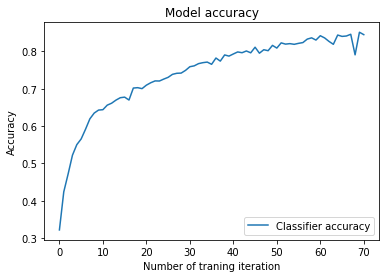

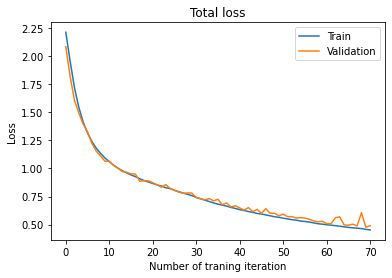

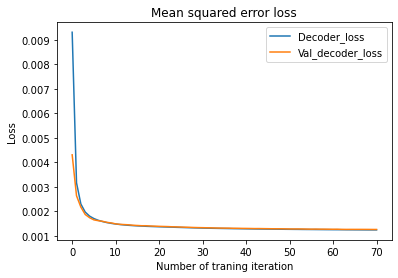

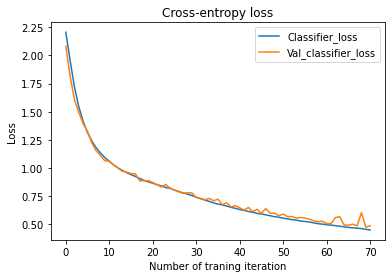

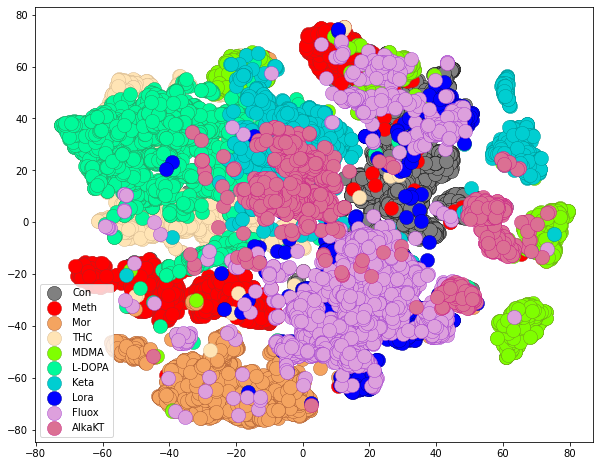

TRAIN: [    0     1     2 ... 19347 19348 19349] VAL: [    4     8     9 ... 19344 19345 19346]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.2293 - decoder_loss: 0.0017 - classifier_loss: 1.2276 - decoder_accuracy: 0.3338 - classifier_accuracy: 0.5809
Epoch 00008: val_loss improved from 1.27238 to 1.20274, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.2293 - decoder_loss: 0.0017 - classifier_loss: 1.2276 - decoder_accuracy: 0.3338 - classifier_accuracy: 0.5809 - val_loss: 1.2027 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.2010 - val_decoder_accuracy: 0.3339 - val_classifier_accuracy: 0.6003 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1754 - decoder_loss: 0.0017 - classifier_loss: 1.1737 - decoder_accuracy: 0.3338 - classifier_accuracy: 0.5994
Epoch 00009: val_loss improved from 1.20274 to 1.16970, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1754 - decoder_loss: 0.0017 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8585 - decoder_loss: 0.0014 - classifier_loss: 0.8571 - decoder_accuracy: 0.3345 - classifier_accuracy: 0.7050
Epoch 00022: val_loss improved from 0.88938 to 0.85667, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8585 - decoder_loss: 0.0014 - classifier_loss: 0.8571 - decoder_accuracy: 0.3345 - classifier_accuracy: 0.7050 - val_loss: 0.8567 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.8552 - val_decoder_accuracy: 0.3350 - val_classifier_accuracy: 0.7028 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8457 - decoder_loss: 0.0014 - classifier_loss: 0.8443 - decoder_accuracy: 0.3346 - classifier_accuracy: 0.7129
Epoch 00023: val_loss did not improve from 0.85667
121/121 [==============================] - 3s 23ms/step - loss: 0.8457 - decoder_loss: 0.0014 - classifier_loss: 0.8443 - decoder_accuracy: 0.3346 -

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.6740 - decoder_loss: 0.0013 - classifier_loss: 0.6727 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.7812
Epoch 00036: val_loss did not improve from 0.71046
121/121 [==============================] - 3s 23ms/step - loss: 0.6740 - decoder_loss: 0.0013 - classifier_loss: 0.6727 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.7812 - val_loss: 0.7269 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7256 - val_decoder_accuracy: 0.3337 - val_classifier_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.6595 - decoder_loss: 0.0013 - classifier_loss: 0.6582 - decoder_accuracy: 0.3352 - classifier_accuracy: 0.7872
Epoch 00037: val_loss did not improve from 0.71046
121/121 [==============================] - 3s 23ms/step - loss: 0.6595 - decoder_loss: 0.0013 - classifier_loss: 0.6582 - decoder_accuracy: 0.3352 - classifier_accuracy: 0.7872 - val_loss: 0.7197

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.5327 - decoder_loss: 0.0013 - classifier_loss: 0.5314 - decoder_accuracy: 0.3372 - classifier_accuracy: 0.8311
Epoch 00050: val_loss improved from 0.59294 to 0.56085, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.5327 - decoder_loss: 0.0013 - classifier_loss: 0.5314 - decoder_accuracy: 0.3372 - classifier_accuracy: 0.8311 - val_loss: 0.5608 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.5596 - val_decoder_accuracy: 0.3348 - val_classifier_accuracy: 0.8191 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.5262 - decoder_loss: 0.0013 - classifier_loss: 0.5249 - decoder_accuracy: 0.3374 - classifier_accuracy: 0.8318
Epoch 00051: val_loss improved from 0.56085 to 0.54827, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.5262 - decoder_loss: 0.0013 - class

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.4757 - decoder_loss: 0.0012 - classifier_loss: 0.4745 - decoder_accuracy: 0.3399 - classifier_accuracy: 0.8503
Epoch 00064: val_loss did not improve from 0.51247

Epoch 00064: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
121/121 [==============================] - 3s 23ms/step - loss: 0.4757 - decoder_loss: 0.0012 - classifier_loss: 0.4745 - decoder_accuracy: 0.3399 - classifier_accuracy: 0.8503 - val_loss: 0.5262 - val_decoder_loss: 0.0012 - val_classifier_loss: 0.5249 - val_decoder_accuracy: 0.3425 - val_classifier_accuracy: 0.8305 - lr: 5.0000e-05
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.4702 - decoder_loss: 0.0012 - classifier_loss: 0.4690 - decoder_accuracy: 0.3399 - classifier_accuracy: 0.8507
Epoch 00065: val_loss improved from 0.51247 to 0.50141, saving model to logs_3/AE_out_weights4.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.4

605/605 [==============================] - 3s 5ms/step - loss: 0.5083 - encoder_loss: 21.0146 - decoder_loss: 0.0013 - classifier_loss: 0.5070 - encoder_accuracy: 0.0014 - decoder_accuracy: 0.3393 - classifier_accuracy: 0.8409
[0.5082718133926392, 21.014629364013672, 0.001255691284313798, 0.5070158243179321, 0.0014470284804701805, 0.33930903673171997, 0.8409302234649658]
{'0': {'precision': 0.8406357388316151, 'recall': 0.8697777777777778, 'f1-score': 0.8549584971603319, 'support': 2250}, '1': {'precision': 0.904, 'recall': 0.904, 'f1-score': 0.904, 'support': 2250}, '2': {'precision': 0.9600985221674877, 'recall': 0.9624691358024692, 'f1-score': 0.9612823674475955, 'support': 2025}, '3': {'precision': 0.8143678160919541, 'recall': 0.7872222222222223, 'f1-score': 0.8005649717514125, 'support': 1800}, '4': {'precision': 0.8405797101449275, 'recall': 0.8838095238095238, 'f1-score': 0.8616527390900649, 'support': 1575}, '5': {'precision': 0.8715265247203176, 'recall': 0.8944444444444445, 

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


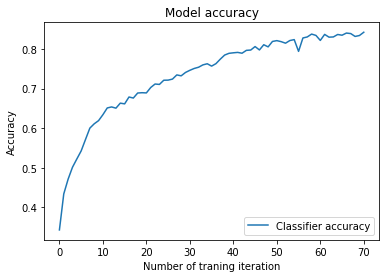

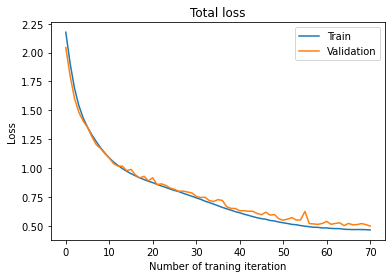

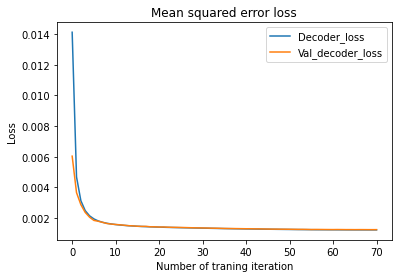

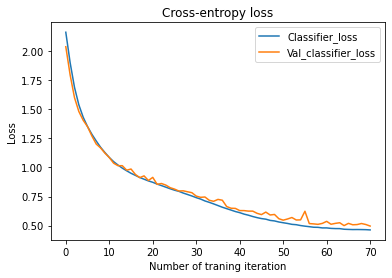

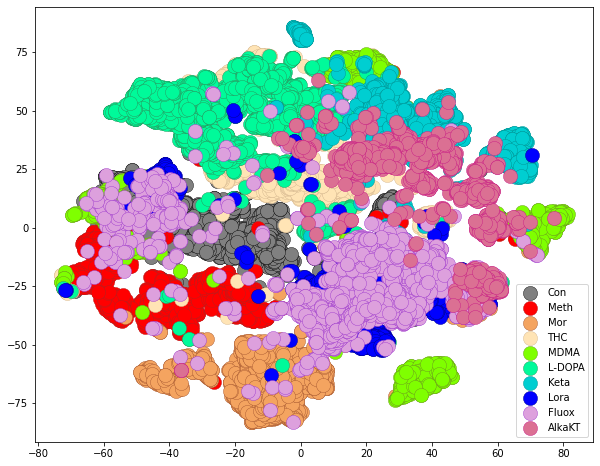

TRAIN: [    0     2     4 ... 19346 19348 19349] VAL: [    1     3     5 ... 19341 19342 19347]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.2038 - decoder_loss: 0.0018 - classifier_loss: 1.2020 - decoder_accuracy: 0.3357 - classifier_accuracy: 0.5975
Epoch 00008: val_loss improved from 1.18656 to 1.16873, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.2038 - decoder_loss: 0.0018 - classifier_loss: 1.2020 - decoder_accuracy: 0.3357 - classifier_accuracy: 0.5975 - val_loss: 1.1687 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.1670 - val_decoder_accuracy: 0.3351 - val_classifier_accuracy: 0.6191 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1559 - decoder_loss: 0.0017 - classifier_loss: 1.1542 - decoder_accuracy: 0.3358 - classifier_accuracy: 0.6158
Epoch 00009: val_loss improved from 1.16873 to 1.11494, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1559 - decoder_loss: 0.0017 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8685 - decoder_loss: 0.0014 - classifier_loss: 0.8671 - decoder_accuracy: 0.3367 - classifier_accuracy: 0.7059
Epoch 00022: val_loss did not improve from 0.88566
121/121 [==============================] - 3s 23ms/step - loss: 0.8685 - decoder_loss: 0.0014 - classifier_loss: 0.8671 - decoder_accuracy: 0.3367 - classifier_accuracy: 0.7059 - val_loss: 0.9229 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.9214 - val_decoder_accuracy: 0.3373 - val_classifier_accuracy: 0.6767 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8586 - decoder_loss: 0.0014 - classifier_loss: 0.8572 - decoder_accuracy: 0.3367 - classifier_accuracy: 0.7055
Epoch 00023: val_loss improved from 0.88566 to 0.87865, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8586 - decoder_loss: 0.0014 - classifier_loss: 0.8572 - decoder_accuracy: 0.3367 -

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7663 - decoder_loss: 0.0013 - classifier_loss: 0.7650 - decoder_accuracy: 0.3380 - classifier_accuracy: 0.7381
Epoch 00036: val_loss improved from 0.80537 to 0.78934, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.7663 - decoder_loss: 0.0013 - classifier_loss: 0.7650 - decoder_accuracy: 0.3380 - classifier_accuracy: 0.7381 - val_loss: 0.7893 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.7880 - val_decoder_accuracy: 0.3390 - val_classifier_accuracy: 0.7367 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.7586 - decoder_loss: 0.0013 - classifier_loss: 0.7573 - decoder_accuracy: 0.3382 - classifier_accuracy: 0.7402
Epoch 00037: val_loss did not improve from 0.78934
121/121 [==============================] - 3s 23ms/step - loss: 0.7586 - decoder_loss: 0.0013 - classifier_loss: 0.7573 - decoder_accuracy: 0.3382 -

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.7044 - decoder_loss: 0.0013 - classifier_loss: 0.7031 - decoder_accuracy: 0.3414 - classifier_accuracy: 0.7583
Epoch 00050: val_loss improved from 0.74447 to 0.74330, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.7044 - decoder_loss: 0.0013 - classifier_loss: 0.7031 - decoder_accuracy: 0.3414 - classifier_accuracy: 0.7583 - val_loss: 0.7433 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7420 - val_decoder_accuracy: 0.3313 - val_classifier_accuracy: 0.7509 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.6984 - decoder_loss: 0.0013 - classifier_loss: 0.6972 - decoder_accuracy: 0.3417 - classifier_accuracy: 0.7621
Epoch 00051: val_loss did not improve from 0.74330
121/121 [==============================] - 3s 23ms/step - loss: 0.6984 - decoder_loss: 0.0013 - classifier_loss: 0.6972 - decoder_accuracy: 0.3417 -

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.6611 - decoder_loss: 0.0012 - classifier_loss: 0.6599 - decoder_accuracy: 0.3441 - classifier_accuracy: 0.7774
Epoch 00064: val_loss did not improve from 0.72036
121/121 [==============================] - 3s 23ms/step - loss: 0.6611 - decoder_loss: 0.0012 - classifier_loss: 0.6599 - decoder_accuracy: 0.3441 - classifier_accuracy: 0.7774 - val_loss: 0.7209 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7197 - val_decoder_accuracy: 0.3456 - val_classifier_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.6557 - decoder_loss: 0.0012 - classifier_loss: 0.6545 - decoder_accuracy: 0.3444 - classifier_accuracy: 0.7767
Epoch 00065: val_loss improved from 0.72036 to 0.71882, saving model to logs_3/AE_out_weights5.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6557 - decoder_loss: 0.0012 - classifier_loss: 0.6545 - decoder_accuracy: 0.3444 -

{'0': {'precision': 0.7380025940337225, 'recall': 0.7586666666666667, 'f1-score': 0.7481919789612098, 'support': 2250}, '1': {'precision': 0.8103448275862069, 'recall': 0.8564444444444445, 'f1-score': 0.8327571305099394, 'support': 2250}, '2': {'precision': 0.8605212355212355, 'recall': 0.8804938271604938, 'f1-score': 0.8703929704661947, 'support': 2025}, '3': {'precision': 0.7553827751196173, 'recall': 0.7016666666666667, 'f1-score': 0.7275345622119815, 'support': 1800}, '4': {'precision': 0.7405721716514955, 'recall': 0.7231746031746031, 'f1-score': 0.7317699967876646, 'support': 1575}, '5': {'precision': 0.8302023121387283, 'recall': 0.8511111111111112, 'f1-score': 0.8405267008046817, 'support': 2700}, '6': {'precision': 0.7891927951967979, 'recall': 0.7511111111111111, 'f1-score': 0.7696811971372803, 'support': 1575}, '7': {'precision': 0.7088757396449704, 'recall': 0.7606349206349207, 'f1-score': 0.733843797856049, 'support': 1575}, '8': {'precision': 0.6852764094143404, 'recall':

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


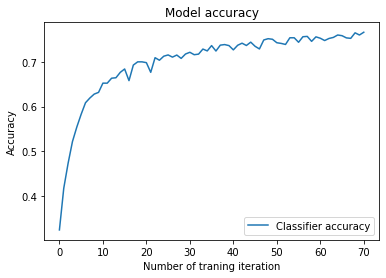

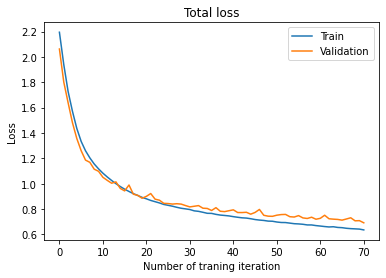

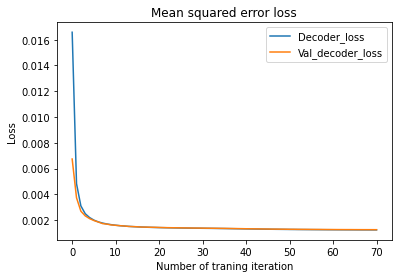

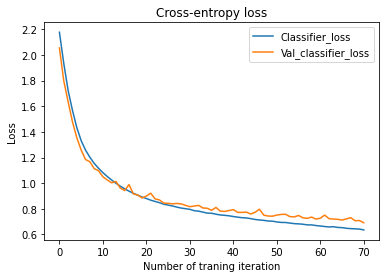

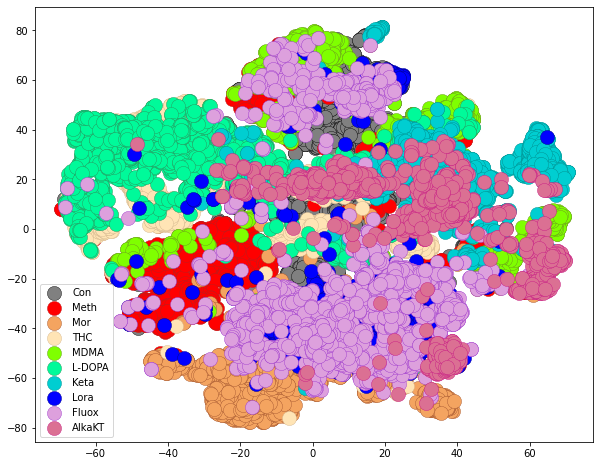

LEARN: [    2     3     5 ... 38696 38698 38699] TEST: [    0     1     4 ... 38690 38694 38697]
StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     3 ... 19347 19348 19349] VAL: [    0    11    13 ... 19332 19335 19343]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_____

121/121 [==============================] - ETA: 0s - loss: 1.3132 - decoder_loss: 0.0017 - classifier_loss: 1.3115 - decoder_accuracy: 0.3358 - classifier_accuracy: 0.5556
Epoch 00007: val_loss improved from 1.35698 to 1.31606, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.3132 - decoder_loss: 0.0017 - classifier_loss: 1.3115 - decoder_accuracy: 0.3358 - classifier_accuracy: 0.5556 - val_loss: 1.3161 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.3144 - val_decoder_accuracy: 0.3359 - val_classifier_accuracy: 0.5496 - lr: 1.0000e-04
Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.2627 - decoder_loss: 0.0017 - classifier_loss: 1.2610 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.5734
Epoch 00008: val_loss improved from 1.31606 to 1.25671, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.2627 - decoder_loss: 0.0017 - classifier_loss: 1

Epoch 21/71
121/121 [==============================] - ETA: 0s - loss: 0.9324 - decoder_loss: 0.0014 - classifier_loss: 0.9310 - decoder_accuracy: 0.3372 - classifier_accuracy: 0.6837
Epoch 00021: val_loss improved from 0.98556 to 0.96445, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.9324 - decoder_loss: 0.0014 - classifier_loss: 0.9310 - decoder_accuracy: 0.3372 - classifier_accuracy: 0.6837 - val_loss: 0.9645 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.9631 - val_decoder_accuracy: 0.3371 - val_classifier_accuracy: 0.6744 - lr: 1.0000e-04
Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.9164 - decoder_loss: 0.0014 - classifier_loss: 0.9150 - decoder_accuracy: 0.3371 - classifier_accuracy: 0.6916
Epoch 00022: val_loss improved from 0.96445 to 0.95365, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.9164 - decoder_loss: 0.0014 - class

Epoch 35/71
121/121 [==============================] - ETA: 0s - loss: 0.7841 - decoder_loss: 0.0014 - classifier_loss: 0.7828 - decoder_accuracy: 0.3371 - classifier_accuracy: 0.7359
Epoch 00035: val_loss improved from 0.84871 to 0.83754, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7841 - decoder_loss: 0.0014 - classifier_loss: 0.7828 - decoder_accuracy: 0.3371 - classifier_accuracy: 0.7359 - val_loss: 0.8375 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.8362 - val_decoder_accuracy: 0.3373 - val_classifier_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7774 - decoder_loss: 0.0014 - classifier_loss: 0.7761 - decoder_accuracy: 0.3372 - classifier_accuracy: 0.7394
Epoch 00036: val_loss improved from 0.83754 to 0.83062, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7774 - decoder_loss: 0.0014 - class

Epoch 49/71
121/121 [==============================] - ETA: 0s - loss: 0.7089 - decoder_loss: 0.0013 - classifier_loss: 0.7076 - decoder_accuracy: 0.3413 - classifier_accuracy: 0.7649
Epoch 00049: val_loss did not improve from 0.77851
121/121 [==============================] - 3s 23ms/step - loss: 0.7089 - decoder_loss: 0.0013 - classifier_loss: 0.7076 - decoder_accuracy: 0.3413 - classifier_accuracy: 0.7649 - val_loss: 0.7813 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7801 - val_decoder_accuracy: 0.3411 - val_classifier_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.7044 - decoder_loss: 0.0013 - classifier_loss: 0.7031 - decoder_accuracy: 0.3418 - classifier_accuracy: 0.7636
Epoch 00050: val_loss improved from 0.77851 to 0.77772, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7044 - decoder_loss: 0.0013 - classifier_loss: 0.7031 - decoder_accuracy: 0.3418 -

Epoch 63/71
121/121 [==============================] - ETA: 0s - loss: 0.6581 - decoder_loss: 0.0013 - classifier_loss: 0.6568 - decoder_accuracy: 0.3467 - classifier_accuracy: 0.7799
Epoch 00063: val_loss improved from 0.74274 to 0.73563, saving model to logs_3/AE_out_weights6.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6581 - decoder_loss: 0.0013 - classifier_loss: 0.6568 - decoder_accuracy: 0.3467 - classifier_accuracy: 0.7799 - val_loss: 0.7356 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7344 - val_decoder_accuracy: 0.3450 - val_classifier_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.6517 - decoder_loss: 0.0013 - classifier_loss: 0.6504 - decoder_accuracy: 0.3470 - classifier_accuracy: 0.7808
Epoch 00064: val_loss did not improve from 0.73563
121/121 [==============================] - 3s 23ms/step - loss: 0.6517 - decoder_loss: 0.0013 - classifier_loss: 0.6504 - decoder_accuracy: 0.3470 -

605/605 [==============================] - 3s 5ms/step - loss: 0.7049 - encoder_loss: 18.8486 - decoder_loss: 0.0012 - classifier_loss: 0.7037 - encoder_accuracy: 0.0019 - decoder_accuracy: 0.3474 - classifier_accuracy: 0.7592
[0.704939067363739, 18.848615646362305, 0.001245197607204318, 0.7036934494972229, 0.0018604651559144258, 0.34737440943717957, 0.7591731548309326]
{'0': {'precision': 0.7621861152141802, 'recall': 0.688, 'f1-score': 0.7231955150665733, 'support': 2250}, '1': {'precision': 0.8604215456674473, 'recall': 0.8164444444444444, 'f1-score': 0.8378563283922463, 'support': 2250}, '2': {'precision': 0.8259144997796386, 'recall': 0.9254320987654321, 'f1-score': 0.8728458313926408, 'support': 2025}, '3': {'precision': 0.7595307917888563, 'recall': 0.7194444444444444, 'f1-score': 0.7389443651925821, 'support': 1800}, '4': {'precision': 0.7240089753178759, 'recall': 0.6146031746031746, 'f1-score': 0.6648351648351648, 'support': 1575}, '5': {'precision': 0.8141025641025641, 'reca

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


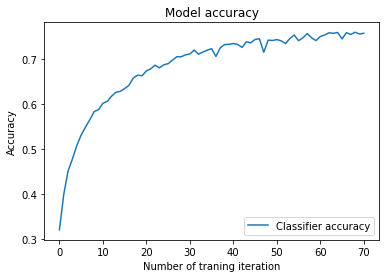

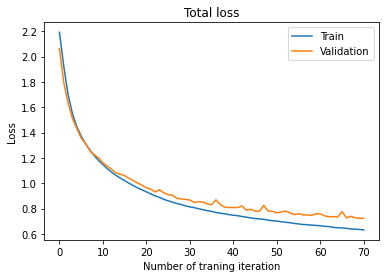

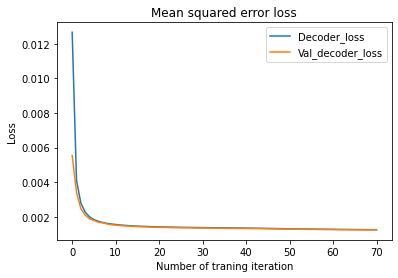

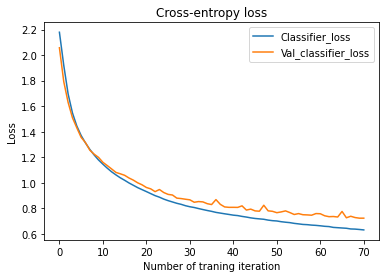

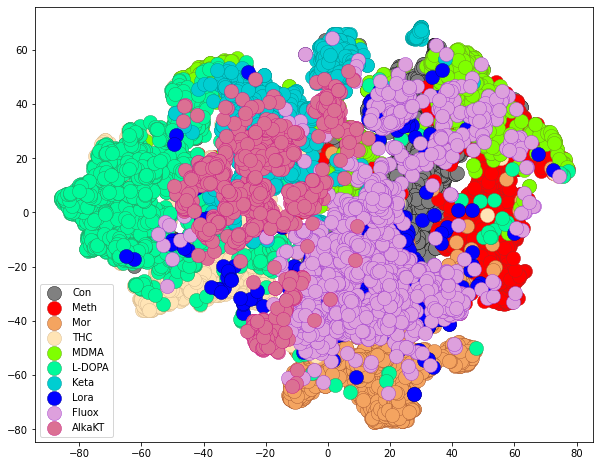

TRAIN: [    0     1     2 ... 19346 19347 19349] VAL: [    7    10    15 ... 19339 19340 19348]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.1591 - decoder_loss: 0.0017 - classifier_loss: 1.1574 - decoder_accuracy: 0.3337 - classifier_accuracy: 0.6182
Epoch 00008: val_loss improved from 1.20773 to 1.12656, saving model to logs_3/AE_out_weights7.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1591 - decoder_loss: 0.0017 - classifier_loss: 1.1574 - decoder_accuracy: 0.3337 - classifier_accuracy: 0.6182 - val_loss: 1.1266 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.1248 - val_decoder_accuracy: 0.3336 - val_classifier_accuracy: 0.6238 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1121 - decoder_loss: 0.0016 - classifier_loss: 1.1104 - decoder_accuracy: 0.3337 - classifier_accuracy: 0.6295
Epoch 00009: val_loss improved from 1.12656 to 1.10499, saving model to logs_3/AE_out_weights7.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1121 - decoder_loss: 0.0016 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8250 - decoder_loss: 0.0014 - classifier_loss: 0.8236 - decoder_accuracy: 0.3334 - classifier_accuracy: 0.7151
Epoch 00022: val_loss improved from 0.87713 to 0.84439, saving model to logs_3/AE_out_weights7.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8250 - decoder_loss: 0.0014 - classifier_loss: 0.8236 - decoder_accuracy: 0.3334 - classifier_accuracy: 0.7151 - val_loss: 0.8444 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.8430 - val_decoder_accuracy: 0.3334 - val_classifier_accuracy: 0.7114 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8087 - decoder_loss: 0.0014 - classifier_loss: 0.8073 - decoder_accuracy: 0.3333 - classifier_accuracy: 0.7257
Epoch 00023: val_loss improved from 0.84439 to 0.83211, saving model to logs_3/AE_out_weights7.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8087 - decoder_loss: 0.0014 - class

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.6375 - decoder_loss: 0.0014 - classifier_loss: 0.6361 - decoder_accuracy: 0.3342 - classifier_accuracy: 0.7912
Epoch 00036: val_loss did not improve from 0.67808
121/121 [==============================] - 3s 23ms/step - loss: 0.6375 - decoder_loss: 0.0014 - classifier_loss: 0.6361 - decoder_accuracy: 0.3342 - classifier_accuracy: 0.7912 - val_loss: 0.6838 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.6824 - val_decoder_accuracy: 0.3343 - val_classifier_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.6277 - decoder_loss: 0.0014 - classifier_loss: 0.6263 - decoder_accuracy: 0.3343 - classifier_accuracy: 0.7941
Epoch 00037: val_loss did not improve from 0.67808
121/121 [==============================] - 3s 23ms/step - loss: 0.6277 - decoder_loss: 0.0014 - classifier_loss: 0.6263 - decoder_accuracy: 0.3343 - classifier_accuracy: 0.7941 - val_loss: 0.6915

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.5495 - decoder_loss: 0.0013 - classifier_loss: 0.5482 - decoder_accuracy: 0.3375 - classifier_accuracy: 0.8229
Epoch 00050: val_loss did not improve from 0.59748
121/121 [==============================] - 3s 23ms/step - loss: 0.5495 - decoder_loss: 0.0013 - classifier_loss: 0.5482 - decoder_accuracy: 0.3375 - classifier_accuracy: 0.8229 - val_loss: 0.5992 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.5979 - val_decoder_accuracy: 0.3355 - val_classifier_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.5478 - decoder_loss: 0.0013 - classifier_loss: 0.5465 - decoder_accuracy: 0.3377 - classifier_accuracy: 0.8228
Epoch 00051: val_loss did not improve from 0.59748
121/121 [==============================] - 3s 23ms/step - loss: 0.5478 - decoder_loss: 0.0013 - classifier_loss: 0.5465 - decoder_accuracy: 0.3377 - classifier_accuracy: 0.8228 - val_loss: 0.6085

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.4964 - decoder_loss: 0.0013 - classifier_loss: 0.4951 - decoder_accuracy: 0.3404 - classifier_accuracy: 0.8421
Epoch 00064: val_loss did not improve from 0.54398
121/121 [==============================] - 3s 23ms/step - loss: 0.4964 - decoder_loss: 0.0013 - classifier_loss: 0.4951 - decoder_accuracy: 0.3404 - classifier_accuracy: 0.8421 - val_loss: 0.5609 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.5596 - val_decoder_accuracy: 0.3382 - val_classifier_accuracy: 0.8173 - lr: 1.0000e-04
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.4918 - decoder_loss: 0.0013 - classifier_loss: 0.4905 - decoder_accuracy: 0.3405 - classifier_accuracy: 0.8449
Epoch 00065: val_loss did not improve from 0.54398
121/121 [==============================] - 3s 23ms/step - loss: 0.4918 - decoder_loss: 0.0013 - classifier_loss: 0.4905 - decoder_accuracy: 0.3405 - classifier_accuracy: 0.8449 - val_loss: 0.5619

605/605 [==============================] - 3s 5ms/step - loss: 0.5327 - encoder_loss: 21.5020 - decoder_loss: 0.0013 - classifier_loss: 0.5315 - encoder_accuracy: 8.2687e-04 - decoder_accuracy: 0.3418 - classifier_accuracy: 0.8259


/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


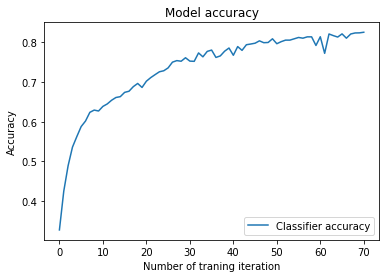

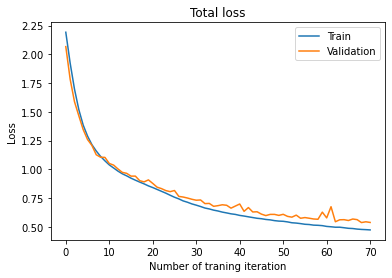

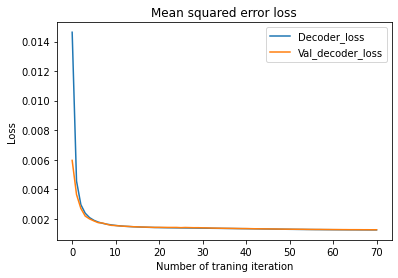

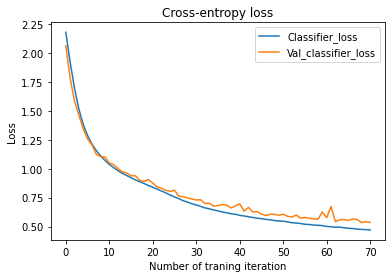

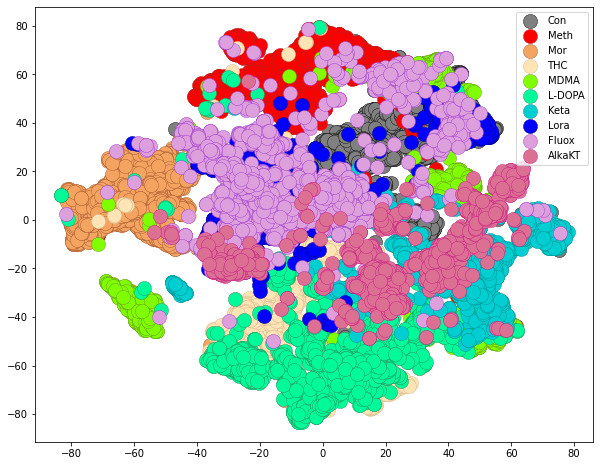

TRAIN: [    0     1     3 ... 19346 19347 19348] VAL: [    2    18    24 ... 19333 19336 19349]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.2371 - decoder_loss: 0.0017 - classifier_loss: 1.2354 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.5786
Epoch 00008: val_loss improved from 1.27602 to 1.21184, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.2371 - decoder_loss: 0.0017 - classifier_loss: 1.2354 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.5786 - val_loss: 1.2118 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.2102 - val_decoder_accuracy: 0.3362 - val_classifier_accuracy: 0.5814 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1877 - decoder_loss: 0.0016 - classifier_loss: 1.1861 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.5995
Epoch 00009: val_loss improved from 1.21184 to 1.18914, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1877 - decoder_loss: 0.0016 - classif

121/121 [==============================] - ETA: 0s - loss: 0.8725 - decoder_loss: 0.0014 - classifier_loss: 0.8711 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.7115
Epoch 00021: val_loss improved from 0.89815 to 0.88532, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8725 - decoder_loss: 0.0014 - classifier_loss: 0.8711 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.7115 - val_loss: 0.8853 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.8839 - val_decoder_accuracy: 0.3366 - val_classifier_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8597 - decoder_loss: 0.0014 - classifier_loss: 0.8583 - decoder_accuracy: 0.3362 - classifier_accuracy: 0.7123
Epoch 00022: val_loss improved from 0.88532 to 0.85901, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8597 - decoder_loss: 0.0014 - classifier_loss: 

Epoch 35/71
121/121 [==============================] - ETA: 0s - loss: 0.7435 - decoder_loss: 0.0013 - classifier_loss: 0.7421 - decoder_accuracy: 0.3370 - classifier_accuracy: 0.7551
Epoch 00035: val_loss did not improve from 0.77553
121/121 [==============================] - 3s 23ms/step - loss: 0.7435 - decoder_loss: 0.0013 - classifier_loss: 0.7421 - decoder_accuracy: 0.3370 - classifier_accuracy: 0.7551 - val_loss: 0.7766 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7753 - val_decoder_accuracy: 0.3366 - val_classifier_accuracy: 0.7351 - lr: 1.0000e-04
Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7387 - decoder_loss: 0.0013 - classifier_loss: 0.7373 - decoder_accuracy: 0.3371 - classifier_accuracy: 0.7592
Epoch 00036: val_loss improved from 0.77553 to 0.76351, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7387 - decoder_loss: 0.0013 - classifier_loss: 0.7373 - decoder_accuracy: 0.3371 -

Epoch 49/71
121/121 [==============================] - ETA: 0s - loss: 0.6698 - decoder_loss: 0.0013 - classifier_loss: 0.6686 - decoder_accuracy: 0.3394 - classifier_accuracy: 0.7821
Epoch 00049: val_loss improved from 0.71421 to 0.71113, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6698 - decoder_loss: 0.0013 - classifier_loss: 0.6686 - decoder_accuracy: 0.3394 - classifier_accuracy: 0.7821 - val_loss: 0.7111 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7098 - val_decoder_accuracy: 0.3420 - val_classifier_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.6651 - decoder_loss: 0.0013 - classifier_loss: 0.6638 - decoder_accuracy: 0.3394 - classifier_accuracy: 0.7866
Epoch 00050: val_loss improved from 0.71113 to 0.70287, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.6651 - decoder_loss: 0.0013 - class

Epoch 63/71
121/121 [==============================] - ETA: 0s - loss: 0.6044 - decoder_loss: 0.0013 - classifier_loss: 0.6031 - decoder_accuracy: 0.3416 - classifier_accuracy: 0.8030
Epoch 00063: val_loss improved from 0.66380 to 0.65428, saving model to logs_3/AE_out_weights8.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6044 - decoder_loss: 0.0013 - classifier_loss: 0.6031 - decoder_accuracy: 0.3416 - classifier_accuracy: 0.8030 - val_loss: 0.6543 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.6530 - val_decoder_accuracy: 0.3391 - val_classifier_accuracy: 0.7848 - lr: 1.0000e-04
Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.5985 - decoder_loss: 0.0013 - classifier_loss: 0.5973 - decoder_accuracy: 0.3421 - classifier_accuracy: 0.8047
Epoch 00064: val_loss did not improve from 0.65428
121/121 [==============================] - 3s 23ms/step - loss: 0.5985 - decoder_loss: 0.0013 - classifier_loss: 0.5973 - decoder_accuracy: 0.3421 -

605/605 [==============================] - 3s 5ms/step - loss: 0.6045 - encoder_loss: 19.8278 - decoder_loss: 0.0013 - classifier_loss: 0.6033 - encoder_accuracy: 0.0000e+00 - decoder_accuracy: 0.3420 - classifier_accuracy: 0.7971
[0.604520320892334, 19.82784080505371, 0.001259256387129426, 0.6032607555389404, 0.0, 0.3420120179653168, 0.7971059679985046]
{'0': {'precision': 0.7870412324422292, 'recall': 0.772, 'f1-score': 0.7794480592326677, 'support': 2250}, '1': {'precision': 0.8552915766738661, 'recall': 0.88, 'f1-score': 0.8674698795180723, 'support': 2250}, '2': {'precision': 0.8642533936651584, 'recall': 0.9432098765432099, 'f1-score': 0.9020070838252656, 'support': 2025}, '3': {'precision': 0.7531645569620253, 'recall': 0.7933333333333333, 'f1-score': 0.7727272727272726, 'support': 1800}, '4': {'precision': 0.8049095607235142, 'recall': 0.7911111111111111, 'f1-score': 0.7979506884406019, 'support': 1575}, '5': {'precision': 0.8760233918128655, 'recall': 0.8322222222222222, 'f1-s

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


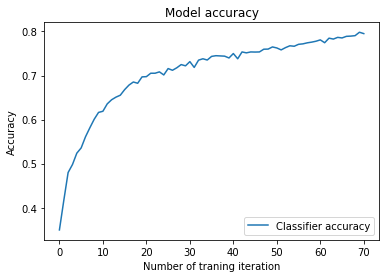

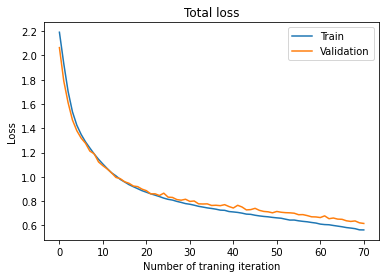

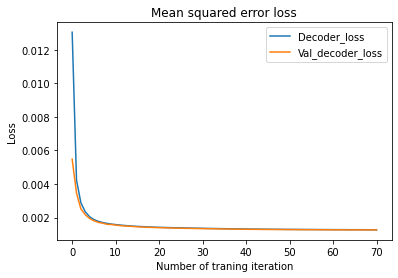

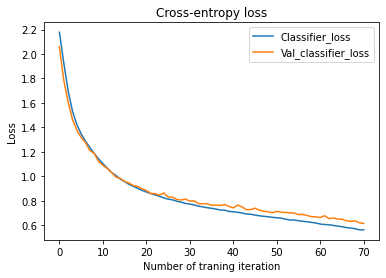

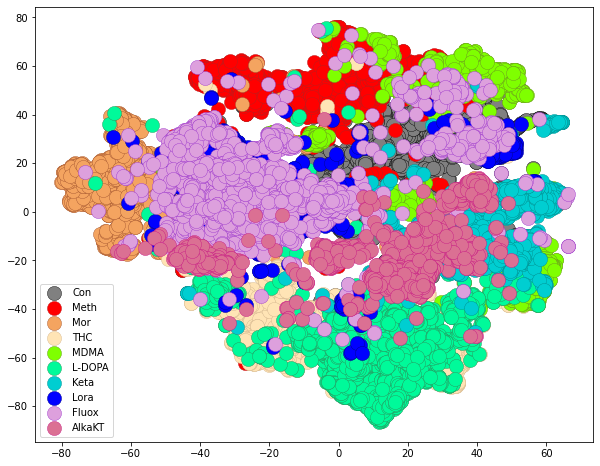

TRAIN: [    0     1     2 ... 19347 19348 19349] VAL: [    4     8     9 ... 19344 19345 19346]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.1610 - decoder_loss: 0.0017 - classifier_loss: 1.1592 - decoder_accuracy: 0.3331 - classifier_accuracy: 0.6335
Epoch 00008: val_loss improved from 1.17235 to 1.11673, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1610 - decoder_loss: 0.0017 - classifier_loss: 1.1592 - decoder_accuracy: 0.3331 - classifier_accuracy: 0.6335 - val_loss: 1.1167 - val_decoder_loss: 0.0017 - val_classifier_loss: 1.1150 - val_decoder_accuracy: 0.3332 - val_classifier_accuracy: 0.6457 - lr: 1.0000e-04
Epoch 9/71
121/121 [==============================] - ETA: 0s - loss: 1.1086 - decoder_loss: 0.0017 - classifier_loss: 1.1069 - decoder_accuracy: 0.3330 - classifier_accuracy: 0.6416
Epoch 00009: val_loss improved from 1.11673 to 1.08323, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.1086 - decoder_loss: 0.0017 - classif

Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8400 - decoder_loss: 0.0014 - classifier_loss: 0.8385 - decoder_accuracy: 0.3332 - classifier_accuracy: 0.7200
Epoch 00022: val_loss improved from 0.87665 to 0.85096, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8400 - decoder_loss: 0.0014 - classifier_loss: 0.8385 - decoder_accuracy: 0.3332 - classifier_accuracy: 0.7200 - val_loss: 0.8510 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.8496 - val_decoder_accuracy: 0.3333 - val_classifier_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 23/71
121/121 [==============================] - ETA: 0s - loss: 0.8266 - decoder_loss: 0.0014 - classifier_loss: 0.8252 - decoder_accuracy: 0.3332 - classifier_accuracy: 0.7237
Epoch 00023: val_loss improved from 0.85096 to 0.84070, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8266 - decoder_loss: 0.0014 - class

Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7330 - decoder_loss: 0.0013 - classifier_loss: 0.7316 - decoder_accuracy: 0.3340 - classifier_accuracy: 0.7565
Epoch 00036: val_loss improved from 0.77661 to 0.76172, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.7330 - decoder_loss: 0.0013 - classifier_loss: 0.7316 - decoder_accuracy: 0.3340 - classifier_accuracy: 0.7565 - val_loss: 0.7617 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.7604 - val_decoder_accuracy: 0.3345 - val_classifier_accuracy: 0.7460 - lr: 1.0000e-04
Epoch 37/71
121/121 [==============================] - ETA: 0s - loss: 0.7254 - decoder_loss: 0.0013 - classifier_loss: 0.7240 - decoder_accuracy: 0.3340 - classifier_accuracy: 0.7584
Epoch 00037: val_loss improved from 0.76172 to 0.75930, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7254 - decoder_loss: 0.0013 - class

Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.6694 - decoder_loss: 0.0013 - classifier_loss: 0.6681 - decoder_accuracy: 0.3367 - classifier_accuracy: 0.7793
Epoch 00050: val_loss improved from 0.72294 to 0.70761, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6694 - decoder_loss: 0.0013 - classifier_loss: 0.6681 - decoder_accuracy: 0.3367 - classifier_accuracy: 0.7793 - val_loss: 0.7076 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7063 - val_decoder_accuracy: 0.3380 - val_classifier_accuracy: 0.7594 - lr: 1.0000e-04
Epoch 51/71
121/121 [==============================] - ETA: 0s - loss: 0.6687 - decoder_loss: 0.0013 - classifier_loss: 0.6674 - decoder_accuracy: 0.3371 - classifier_accuracy: 0.7787
Epoch 00051: val_loss did not improve from 0.70761
121/121 [==============================] - 3s 23ms/step - loss: 0.6687 - decoder_loss: 0.0013 - classifier_loss: 0.6674 - decoder_accuracy: 0.3371 -

Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.6223 - decoder_loss: 0.0013 - classifier_loss: 0.6211 - decoder_accuracy: 0.3435 - classifier_accuracy: 0.7959
Epoch 00064: val_loss improved from 0.67224 to 0.66825, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.6223 - decoder_loss: 0.0013 - classifier_loss: 0.6211 - decoder_accuracy: 0.3435 - classifier_accuracy: 0.7959 - val_loss: 0.6683 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.6670 - val_decoder_accuracy: 0.3421 - val_classifier_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 65/71
121/121 [==============================] - ETA: 0s - loss: 0.6171 - decoder_loss: 0.0013 - classifier_loss: 0.6158 - decoder_accuracy: 0.3438 - classifier_accuracy: 0.7984
Epoch 00065: val_loss improved from 0.66825 to 0.66284, saving model to logs_3/AE_out_weights9.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6171 - decoder_loss: 0.0013 - class

605/605 [==============================] - 3s 5ms/step - loss: 0.6571 - encoder_loss: 20.9750 - decoder_loss: 0.0012 - classifier_loss: 0.6558 - encoder_accuracy: 0.0078 - decoder_accuracy: 0.3467 - classifier_accuracy: 0.7744


/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


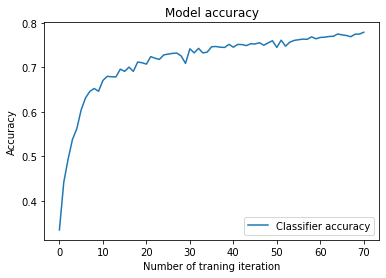

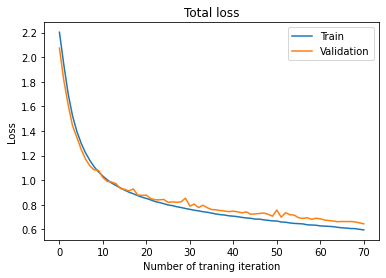

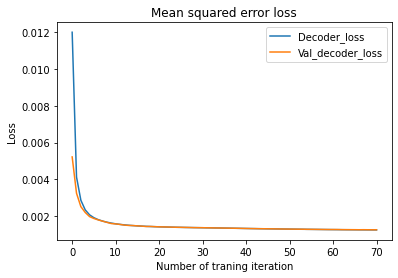

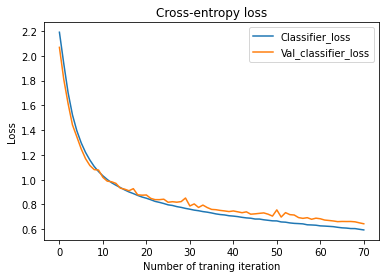

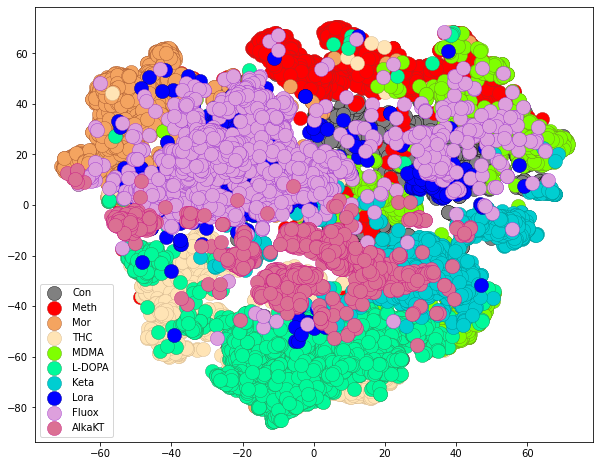

TRAIN: [    0     2     4 ... 19346 19348 19349] VAL: [    1     3     5 ... 19341 19342 19347]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 800, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 800, 16)        496       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 800, 16)        64        
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 80, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 80, 8)          1288      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 80, 8)          32        
_____________________________

121/121 [==============================] - ETA: 0s - loss: 1.2260 - decoder_loss: 0.0018 - classifier_loss: 1.2241 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.6008
Epoch 00007: val_loss improved from 1.23990 to 1.18410, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 23ms/step - loss: 1.2260 - decoder_loss: 0.0018 - classifier_loss: 1.2241 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.6008 - val_loss: 1.1841 - val_decoder_loss: 0.0019 - val_classifier_loss: 1.1823 - val_decoder_accuracy: 0.3349 - val_classifier_accuracy: 0.6134 - lr: 1.0000e-04
Epoch 8/71
121/121 [==============================] - ETA: 0s - loss: 1.1700 - decoder_loss: 0.0018 - classifier_loss: 1.1683 - decoder_accuracy: 0.3351 - classifier_accuracy: 0.6174
Epoch 00008: val_loss improved from 1.18410 to 1.12556, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 24ms/step - loss: 1.1700 - decoder_loss: 0.0018 - classifier_loss:

Epoch 21/71
121/121 [==============================] - ETA: 0s - loss: 0.8731 - decoder_loss: 0.0014 - classifier_loss: 0.8717 - decoder_accuracy: 0.3352 - classifier_accuracy: 0.7074
Epoch 00021: val_loss improved from 0.89640 to 0.86431, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.8731 - decoder_loss: 0.0014 - classifier_loss: 0.8717 - decoder_accuracy: 0.3352 - classifier_accuracy: 0.7074 - val_loss: 0.8643 - val_decoder_loss: 0.0015 - val_classifier_loss: 0.8629 - val_decoder_accuracy: 0.3362 - val_classifier_accuracy: 0.7088 - lr: 1.0000e-04
Epoch 22/71
121/121 [==============================] - ETA: 0s - loss: 0.8583 - decoder_loss: 0.0014 - classifier_loss: 0.8569 - decoder_accuracy: 0.3353 - classifier_accuracy: 0.7143
Epoch 00022: val_loss improved from 0.86431 to 0.84357, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.8583 - decoder_loss: 0.0014 - cla

Epoch 35/71
121/121 [==============================] - ETA: 0s - loss: 0.7509 - decoder_loss: 0.0014 - classifier_loss: 0.7495 - decoder_accuracy: 0.3361 - classifier_accuracy: 0.7530
Epoch 00035: val_loss did not improve from 0.78655
121/121 [==============================] - 3s 23ms/step - loss: 0.7509 - decoder_loss: 0.0014 - classifier_loss: 0.7495 - decoder_accuracy: 0.3361 - classifier_accuracy: 0.7530 - val_loss: 0.7895 - val_decoder_loss: 0.0014 - val_classifier_loss: 0.7881 - val_decoder_accuracy: 0.3367 - val_classifier_accuracy: 0.7346 - lr: 1.0000e-04
Epoch 36/71
121/121 [==============================] - ETA: 0s - loss: 0.7469 - decoder_loss: 0.0013 - classifier_loss: 0.7456 - decoder_accuracy: 0.3363 - classifier_accuracy: 0.7540
Epoch 00036: val_loss improved from 0.78655 to 0.75603, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 24ms/step - loss: 0.7469 - decoder_loss: 0.0013 - classifier_loss: 0.7456 - decoder_accuracy: 0.3363 

Epoch 49/71
121/121 [==============================] - ETA: 0s - loss: 0.6811 - decoder_loss: 0.0013 - classifier_loss: 0.6798 - decoder_accuracy: 0.3397 - classifier_accuracy: 0.7782
Epoch 00049: val_loss did not improve from 0.70044
121/121 [==============================] - 3s 23ms/step - loss: 0.6811 - decoder_loss: 0.0013 - classifier_loss: 0.6798 - decoder_accuracy: 0.3397 - classifier_accuracy: 0.7782 - val_loss: 0.7049 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.7036 - val_decoder_accuracy: 0.3415 - val_classifier_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 50/71
121/121 [==============================] - ETA: 0s - loss: 0.6785 - decoder_loss: 0.0013 - classifier_loss: 0.6772 - decoder_accuracy: 0.3400 - classifier_accuracy: 0.7776
Epoch 00050: val_loss improved from 0.70044 to 0.69110, saving model to logs_3/AE_out_weights10.h5
121/121 [==============================] - 3s 23ms/step - loss: 0.6785 - decoder_loss: 0.0013 - classifier_loss: 0.6772 - decoder_accuracy: 0.3400 

Epoch 63/71
121/121 [==============================] - ETA: 0s - loss: 0.6261 - decoder_loss: 0.0013 - classifier_loss: 0.6249 - decoder_accuracy: 0.3438 - classifier_accuracy: 0.7931
Epoch 00063: val_loss did not improve from 0.65487
121/121 [==============================] - 3s 23ms/step - loss: 0.6261 - decoder_loss: 0.0013 - classifier_loss: 0.6249 - decoder_accuracy: 0.3438 - classifier_accuracy: 0.7931 - val_loss: 0.6555 - val_decoder_loss: 0.0013 - val_classifier_loss: 0.6542 - val_decoder_accuracy: 0.3434 - val_classifier_accuracy: 0.7845 - lr: 1.0000e-04
Epoch 64/71
121/121 [==============================] - ETA: 0s - loss: 0.6229 - decoder_loss: 0.0013 - classifier_loss: 0.6216 - decoder_accuracy: 0.3440 - classifier_accuracy: 0.7935
Epoch 00064: val_loss did not improve from 0.65487
121/121 [==============================] - 3s 23ms/step - loss: 0.6229 - decoder_loss: 0.0013 - classifier_loss: 0.6216 - decoder_accuracy: 0.3440 - classifier_accuracy: 0.7935 - val_loss: 0.6598

605/605 [==============================] - 3s 5ms/step - loss: 0.6458 - encoder_loss: 19.6220 - decoder_loss: 0.0012 - classifier_loss: 0.6446 - encoder_accuracy: 2.5840e-04 - decoder_accuracy: 0.3408 - classifier_accuracy: 0.7794
[0.645828366279602, 19.621952056884766, 0.0012402618303894997, 0.6445883512496948, 0.00025839792215265334, 0.34077712893486023, 0.7793798446655273]
{'0': {'precision': 0.7457091237579042, 'recall': 0.7337777777777778, 'f1-score': 0.7396953405017921, 'support': 2250}, '1': {'precision': 0.8124218424343477, 'recall': 0.8662222222222222, 'f1-score': 0.8384598838459884, 'support': 2250}, '2': {'precision': 0.8837863167760075, 'recall': 0.931358024691358, 'f1-score': 0.906948785765809, 'support': 2025}, '3': {'precision': 0.7450753186558516, 'recall': 0.7144444444444444, 'f1-score': 0.7294384571752695, 'support': 1800}, '4': {'precision': 0.7083073079325422, 'recall': 0.72, 'f1-score': 0.7141057934508815, 'support': 1575}, '5': {'precision': 0.861322188449848, 're

/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/brain/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_accuracy', 'classifier_accuracy', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_accuracy', 'val_classifier_accuracy', 'lr'])


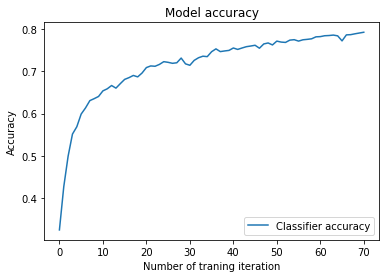

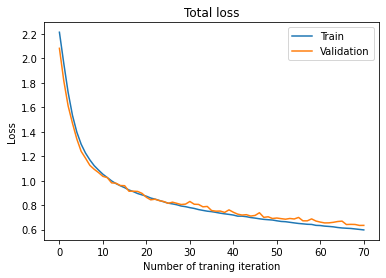

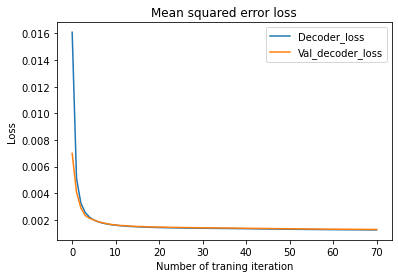

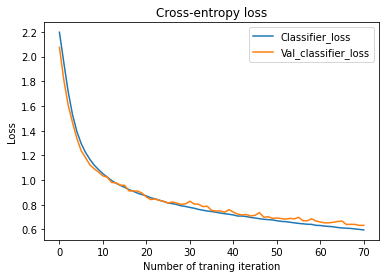

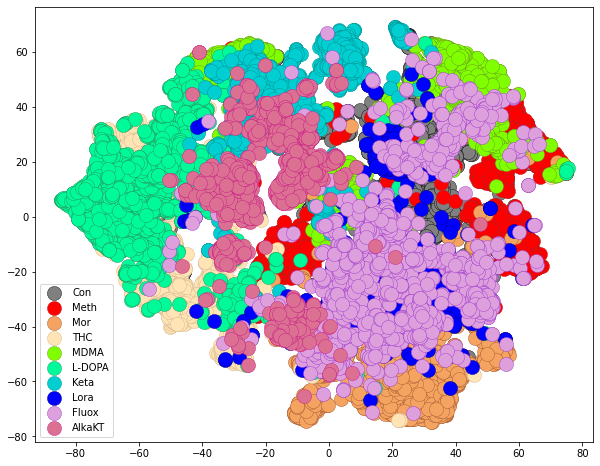

In [17]:
(val_clas_acc, loss, val_loss, dec_loss, val_dec_loss, clas_loss, val_clas_loss, y_true_all_data, y_pred_all_data, 
 scores_all_data, clas_report_all_data, train_xr, z, fold) = fit_model(X = X_new, y = y, epochs = 71, batch_size = 128)

In [18]:
# Report classifier_accuracy
val_classifier_accuracy = scores_all_data[:,:,-1].reshape(-1)*100
mean_classifier_accuracy = mean(val_classifier_accuracy) 
sem_classifier_accuracy = sem(val_classifier_accuracy)
 
print("Mean:", mean_classifier_accuracy, "SEM:", sem_classifier_accuracy)

Mean: 79.98191237449646 SEM: 1.062117811853393


/tmp/ipykernel_2412/2271180981.py:3: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_classifier_accuracy = mean(val_classifier_accuracy)


In [19]:
# # Export classification_report
# xx = []
# for i in range (fold):
#     a = clas_report_all_data.reshape(-1)[i].get('macro avg')
#     x = a.get("f1-score")
#     xx.append(x)

In [20]:
val_clas_loss.shape

(2, 5, 71)

In [23]:
def plot_acc_loss_mean(val_clas_acc, loss, val_loss, dec_loss, val_dec_loss, clas_loss, val_clas_loss):
    val_clas_accu = val_clas_acc.reshape(-1, val_clas_acc.shape[2])
    val_clas_accu = np.swapaxes(val_clas_accu, 0, 1)
    val_clas_aver = np.average(val_clas_accu, axis=1)*100
    val_clas_sem = stats.sem(val_clas_accu, axis=1)*100
    
    losss = loss.reshape(-1, loss.shape[2])
    losss = np.swapaxes(losss, 0, 1)
    loss_aver = np.average(losss, axis=1)
    loss_sem = stats.sem(losss, axis=1)
    
    val_losss = val_loss.reshape(-1, val_loss.shape[2])
    val_losss = np.swapaxes(val_losss, 0, 1)
    val_loss_aver = np.average(val_losss, axis=1)
    val_loss_sem = stats.sem(val_losss, axis=1)
    
    dec_losss = dec_loss.reshape(-1, dec_loss.shape[2])
    dec_losss = np.swapaxes(dec_losss, 0, 1)
    dec_loss_aver = np.average(dec_losss, axis=1)
    dec_loss_sem = stats.sem(dec_losss, axis=1)
    
    val_dec_losss = val_dec_loss.reshape(-1, val_dec_loss.shape[2])
    val_dec_losss = np.swapaxes(val_dec_losss, 0, 1)
    val_dec_loss_aver = np.average(val_dec_losss, axis=1)
    val_dec_loss_sem = stats.sem(val_dec_losss, axis=1)
    
    clas_losss = clas_loss.reshape(-1, clas_loss.shape[2])
    clas_losss = np.swapaxes(clas_losss, 0, 1)
    clas_loss_aver = np.average(clas_losss, axis=1)
    clas_loss_sem = stats.sem(clas_losss, axis=1)
    
    val_clas_losss = val_clas_loss.reshape(-1, val_clas_loss.shape[2])
    val_clas_losss = np.swapaxes(val_clas_losss, 0, 1)
    val_clas_loss_aver = np.average(val_clas_losss, axis=1)
    val_clas_loss_sem = stats.sem(val_clas_losss, axis=1)

    
    sns.set()
    # x = np.arange(len(val_classifier_average))
    x = np.arange(71) # limit x axis
    plt.figure(figsize=(10, 7.3))
    plt.plot(x, val_clas_aver, 'b-', label='Classifier accuracy')
    plt.fill_between(x, val_clas_aver - val_clas_sem, val_clas_aver + val_clas_sem, color='b', alpha=0.2)
    plt.title('Model accuracy', fontdict=dict(weight='bold'))
    plt.ylabel('Accuracy', fontdict=dict(weight='bold'))
    plt.xlabel('Number of traning iteration', fontdict=dict(weight='bold'))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 7.3))
    plt.plot(x, loss_aver, 'b-', label='Training')
    plt.fill_between(x, loss_aver - loss_sem, loss_aver + loss_sem, color='b', alpha=0.2)
    plt.plot(x, val_loss_aver, 'r--', label='Validation')
    plt.fill_between(x, val_loss_aver - val_loss_sem, val_loss_aver + val_loss_sem, color='r', alpha=0.2)
    plt.title('Total loss', fontdict=dict(weight='bold'))
    plt.ylabel('Loss', fontdict=dict(weight='bold'))
    plt.xlabel('Number of traning iteration', fontdict=dict(weight='bold'))
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 7.3))
    plt.plot(x, dec_loss_aver, 'b-', label='Training')
    plt.fill_between(x, dec_loss_aver - dec_loss_sem, dec_loss_aver + dec_loss_sem, color='b', alpha=0.2)
    plt.plot(x, val_dec_loss_aver, 'r--', label='Validation')
    plt.fill_between(x, val_dec_loss_aver - val_dec_loss_sem, val_dec_loss_aver + val_dec_loss_sem, color='r', alpha=0.2)
    plt.title('Mean square error loss', fontdict=dict(weight='bold'))
    plt.ylabel('Loss', fontdict=dict(weight='bold'))
    plt.xlabel('Number of traning iteration', fontdict=dict(weight='bold'))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 7.3))
    plt.plot(x, clas_loss_aver, 'b-', label='Training')
    plt.fill_between(x, clas_loss_aver - clas_loss_sem, clas_loss_aver + clas_loss_sem, color='b', alpha=0.2)
    plt.plot(x, val_clas_loss_aver, 'r--', label='Validation')
    plt.fill_between(x, val_clas_loss_aver - val_clas_loss_sem, val_clas_loss_aver + val_clas_loss_sem, color='r', alpha=0.2)
    plt.title('Cross-entropy loss', fontdict=dict(weight='bold'))
    plt.ylabel('Loss', fontdict=dict(weight='bold'))
    plt.xlabel('Number of traning iteration', fontdict=dict(weight='bold'))
    plt.legend()
    plt.show()

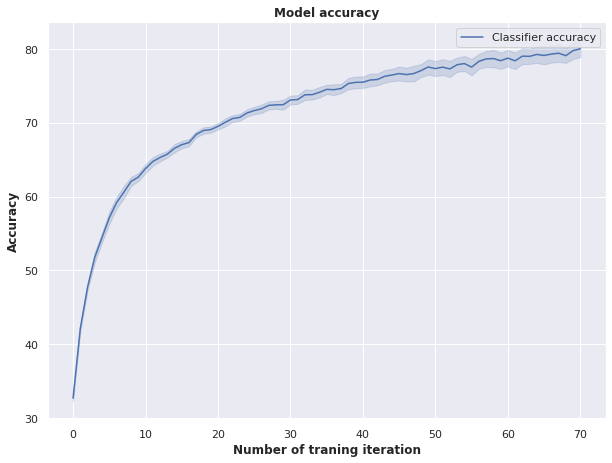

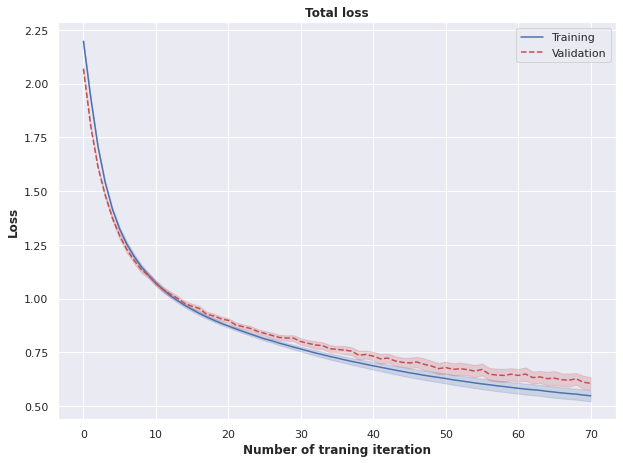

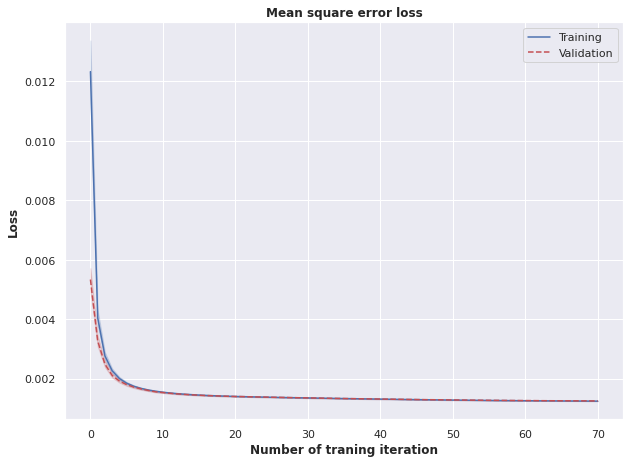

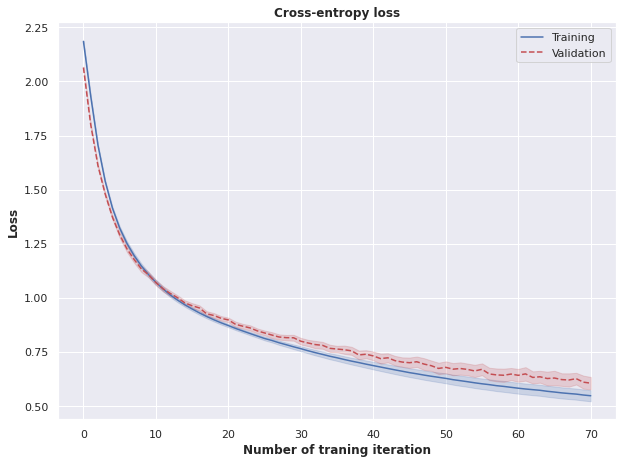

In [24]:
plot_acc_loss_mean(val_clas_acc, loss, val_loss, dec_loss, val_dec_loss, clas_loss, val_clas_loss)

In [25]:
y_true = y_true_all_data.reshape(-1)
y_pred = y_pred_all_data.reshape(-1)

In [26]:
# y_true = []
# for i in range(fold):
#     for y in y_true_all_data.reshape(-1)[i]:
#         y_true.append(y)
#         y_true_all = np.array(y_true)
        
# y_pred = []import matplotlib.pyplot as plt
# for i in range(fold):
#     for y in y_pred_all_data.reshape(-1)[i]:
#         y_pred.append(y)
#         y_pred_all = np.array(y_pred)

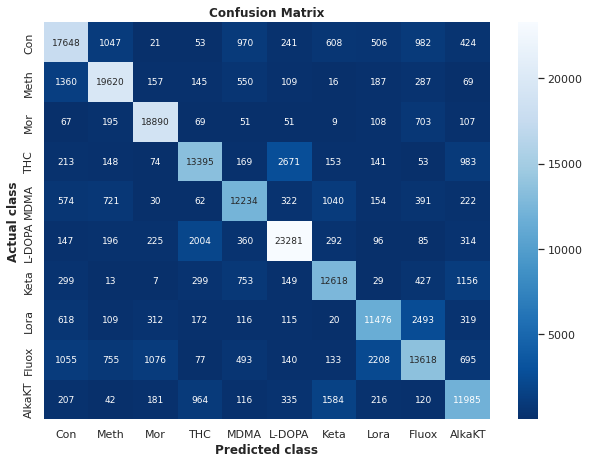

In [29]:
actual_data = y_true
predicted_data = y_pred
cm = confusion_matrix(actual_data, predicted_data)
# print(cm)
plt.figure(figsize=(10, 7.3))
ax = sns.heatmap(cm, annot=True, fmt='g',cmap="Blues_r",annot_kws={'size':9});
ax.set_title('Confusion Matrix', fontdict=dict(weight='bold'));
ax.set_xlabel('Predicted class', fontdict=dict(weight='bold'))
ax.set_ylabel('Actual class', fontdict=dict(weight='bold'));
# ax.xaxis.set_ticklabels(['Con', 'Meth'])
# ax.xaxis.set_ticklabels(['Con', 'Meth'])
ax.yaxis.set_ticklabels(['Con', 'Meth', 'Mor','THC','MDMA','L-DOPA', 'Keta','Lora','Fluox','AlkaKT'])
ax.xaxis.set_ticklabels(['Con', 'Meth', 'Mor','THC','MDMA','L-DOPA', 'Keta','Lora','Fluox','AlkaKT'])
plt.show()

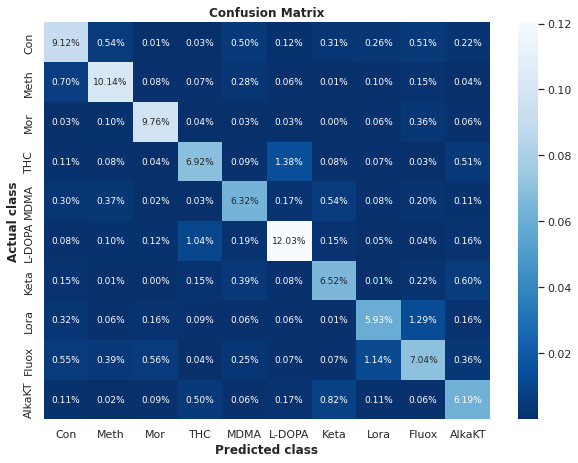

In [31]:
cm = confusion_matrix(y_true, y_pred)
# print(cm)
plt.figure(figsize=(10, 7.3))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap="Blues_r",annot_kws={'size':9})
ax.set_title('Confusion Matrix', fontdict=dict(weight='bold'));
ax.set_xlabel('Predicted class', fontdict=dict(weight='bold'))
ax.set_ylabel('Actual class', fontdict=dict(weight='bold'));
# ax.xaxis.set_ticklabels(['Con', 'Meth'])
# ax.xaxis.set_ticklabels(['Con', 'Meth'])
ax.yaxis.set_ticklabels(['Con', 'Meth', 'Mor','THC','MDMA','L-DOPA', 'Keta','Lora','Fluox','AlkaKT'])
ax.xaxis.set_ticklabels(['Con', 'Meth', 'Mor','THC','MDMA','L-DOPA', 'Keta','Lora','Fluox','AlkaKT'])
plt.show()

In [ ]:
# T = np.array([ y  for y in y_true_all_data.reshape(-1)[i] for i in range(45)])
# P = np.array([ y  for y in y_pred_all_data.reshape(-1)[i] for i in range(45)])

In [ ]:
# y_true = []
# for i in range(36):
#     for y in y_true_all_data.reshape(-1)[i]:
#         y_true.append(y)
#         y_true_all = np.array(y_true)
        
# y_pred = []
# for i in range(4):
#     for y in y_pred_all_data.reshape(-1)[i]:
#         y_pred.append(y)
#         y_pred_all = np.array(y_true)

In [ ]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# X = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7],[8, 8], [9, 9], [10, 10], [11, 11]])
# y = np.array([0, 0,0,1,1,1, 1,1,1,1,1, 1])
# ys = np.array([0,0,0,1,1,1,2,2,2,3,3,3])
# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X, ys)
# print(skf)
# StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
# for learn_index, test_index in skf.split(X, ys):
#     print("LEARN:", learn_index, "TEST:", test_index)
#     X_learn, X_test = X[learn_index], X[test_index]
#     print('X_learn:', X_learn)
#     y_learn, y_test = y[learn_index], y[test_index]
#     print('y_learn:', y_learn)
#     ys_learn, ys_test = ys[learn_index], ys[test_index]
#     print('ys_learn:', ys_learn)
    
#     skf_train = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
#     skf_train.get_n_splits(X_learn, ys_learn)
#     print(skf_train)
#     for train_index, val_index in skf_train.split(X_learn, ys_learn):
#         print("TRAIN:", train_index, "VAL:", val_index)
#         X_train, X_val = X_learn[train_index], X_learn[val_index]
#         print('X_train:', X_train)
#         print('X_val:', X_val)
#         y_train, y_val = y_learn[train_index], y_learn[val_index]
#         print('y_train:', y_train)
#         ys_train, ys_val = ys_learn[train_index], ys_learn[val_index]
#         print('ys_train:', ys_train)